<a href="https://colab.research.google.com/github/xiejiongru/DL_raster_tp2/blob/main/Deep_Learning_for_Temporal_Data_TSI__XIE_Jiongru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Satellite Superspectral Images Time Series

In this exercise, we will implement several spatio-temporal deep learning architectures for classifying multispectral satellite image sequences of agricultural parcels.
In particular, we will implement a **GRU**, **Temporal Convolutions**, a **convolutional LSTM**, and Transformer-like **Temporal Attention Encoder**.

$\qquad\qquad\qquad\qquad$<img src="https://drive.google.com/uc?id=1Bkqy2n1MW2uOSC3umi__B-Ci3EqIGhvZ" alt="Drawing"  width="500"/>

The data considered is composed of $2\,000$ agricultural parcels for the training test and $800$ parcels for the test set. Each parcel is associated with a Satellite Image Time Series (SITS) of $24$ image of resolution $32\times 32$ and with $10$ spectral bands, captured with the Sentinel-2 optical satellite. The $24$ dates corresponds to some of the acquisitions between October 2018 and October 2019, as provided by THEIA.

The selected parcels follow a nomenclature of $8$ agricultural classes:

> **Class Index** | **Class Name**
> --- | ---
> 0  | Meadow
> 1  | Durum Wheat
> 2  | Spring Cereal
> 3  | Sorgho
> 4  | Leguminous
> 5  | Fodder
> 6  | Ligneous
> 7  | Grapevine

As usual, complete the `#TODO`, make sure the `assert` passes and use `print` to visualize the shape and content of tensors.

# 1 Preliminaries

Since this is the 4th TD, and we will try to implement as many architetcure as possible, we will go quickly on the non-specific code. See the other TD if you need more context.

## 1.1 Librairies

In [ ]:
#install on the VM libraries that are not installed by default
!pip install torchnet
!pip install PyDrive
!pip install mock
#general purpose libraires
import math
import numpy as np
from functools import partial
import mock
#format libraries
import h5py
#visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
#machine learning tools
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
#deep learning tools
import torch
import torchnet as tnt
import torch.nn.functional as nnf
import torch.nn as nn
import copy
import torch.optim as optim
from tqdm.auto import tqdm
#collab specific libraries
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.2 MB/s eta 0:00:00
  Created wheel for torchnet: filename=tor

## 1.2 Data Download

Connect to your Google account to get the authorization to link to my drive. Launch the next cell, click the link, select your account, and click `authorize`. Copy and paste the verification code in the box below.

In [ ]:
#Authentification
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':'1oT8AgKC1ZPaVSbrhJ0BrKcL4_pk3nWn2'})
downloaded.GetContentFile('data_sits.h5') #may take up to 90s

In [ ]:
#Data loading
data_file = h5py.File("data_sits.h5",'r')

data_train_raw = data_file['train_data'][:]
labels_train = data_file['train_labels'][:]
data_test_raw = data_file['test_data'][:]
labels_test = data_file['test_labels'][:]
del data_file

n_train = data_train_raw.shape[0]
n_test = data_test_raw.shape[0]

#we permute the trainset to makes creating a validation set easier later on
np.random.seed(0)
permutation = np.random.permutation(n_train)
data_train_raw = data_train_raw[permutation,:,:,:,:]
labels_train = labels_train[permutation]

class_names = ["Meadow", "Durum Wheat", "Spring Cereal", "Sorgho", "Leguminous", "Fodder", "Ligneous", "Grapevine"]

print("%d SITS for training, %d SITS for testing" % (n_train, n_test))
print("Train is of size: %d x %d x %d x %d x %d" % (data_train_raw.shape))

2000 SITS for training, 800 SITS for testing
Train is of size: 2000 x 24 x 10 x 32 x 32




## 1.3 Data Normalization

 We first normalize the data **spatially**. For a given date and spectral channel, we compute the mean and std over all pixels of all train sequence.

Q1) <font color='red'>Why do we only normalize spatially and not temporally as well ?</font>


1.   Preserving Temporal Trends:      
<font color='blue'>Satellite image sequences (SITS) capture changes over time. Normalizing temporally (across different timestamps) might distort these temporal variations, making it harder for the model to learn meaningful trends.</font>
2.   Spatial Variation is Less Informative:    
<font color='blue'>Within each timestamp, different pixels can have different reflectance values due to varying land cover types, lighting conditions, and atmospheric effects. Normalizing spatially ensures that each pixel’s values are on a comparable scale, reducing the impact of local variations.</font>
3.   Temporal Consistency:    
<font color='blue'>If you normalize over time, you might artificially remove seasonal variations or trends that are critical for classification tasks. For example, crops have seasonal growth cycles, and normalizing across time could obscure these patterns.</font>   
4.   Standard Approach in Remote Sensing:     
<font color='blue'>In many remote sensing tasks, it is common to normalize spatially while keeping the temporal structure intact. This allows the model to learn meaningful temporal relationships without distortion.</font>


In [ ]:
#compute mean and std fo non NaN values (we keep the original dimension to facilitate broadcasting)
means = np.mean(data_train_raw,axis=(0,3,4), keepdims=True)
stds = np.std(data_train_raw, axis=(0,3,4), keepdims=True)
print("Size of means = [%d, %d, %d, %d, %d]" % (means.shape))

#normalize data to be of mean 0 and std 1
data_train = (data_train_raw - means) / stds
data_test = (data_test_raw - means) / stds

del data_train_raw, data_test_raw

#check that the code is correct
assert(np.all([np.abs(np.nanmean(data_train[:,1,2,:,:]))<1e-4 for i in range(10)]))
assert(np.all([np.abs(np.nanstd(data_train[:,3,4,:,:])-1)<1e-4 for i in range(10)]))

Size of means = [1, 24, 10, 1, 1]



## 1.4 Data Loader

Any deep learning pipeline rely on a dataloader, which loads a single element (here a SITS)

In [ ]:
def sits_loader(sits_index, train=True, average=False):
  """
  load a SITS and returns the observation and associated ground truth
  INPUT:
  sits_index (int), index of the sits
  train (bool), train = True if in the train set, False for the test set
  OUTPUT
  sits, [24 x 32 x 32 x 10] float tensor
  label, long int, containing the ground truth class
  """
  if train:
    sits = data_train[sits_index,:,:,:,:]
    label = labels_train[sits_index]
  else:
    sits = data_test[sits_index,:,:,:,:]
    label = labels_test[sits_index]

  #create torch tensors
  sits = torch.from_numpy(sits.astype('f4')) # use half-float to save space
  label = torch.Tensor([label]).long() # ground truth must have long int type

  return sits, label

In [ ]:
patch, label = sits_loader(500)
print("The image patch is of shape : %d x %d x %d x %d" % (patch.shape))
print("and its label is %s" % (class_names[label]))

The image patch is of shape : 24 x 10 x 32 x 32
and its label is Leguminous


## 1.5 Data Visualization

Writing some visualization functions to explore the data and the results is very important.
Read and undertsand the definition of `view_patch_RGB` and `show_random_patches`.

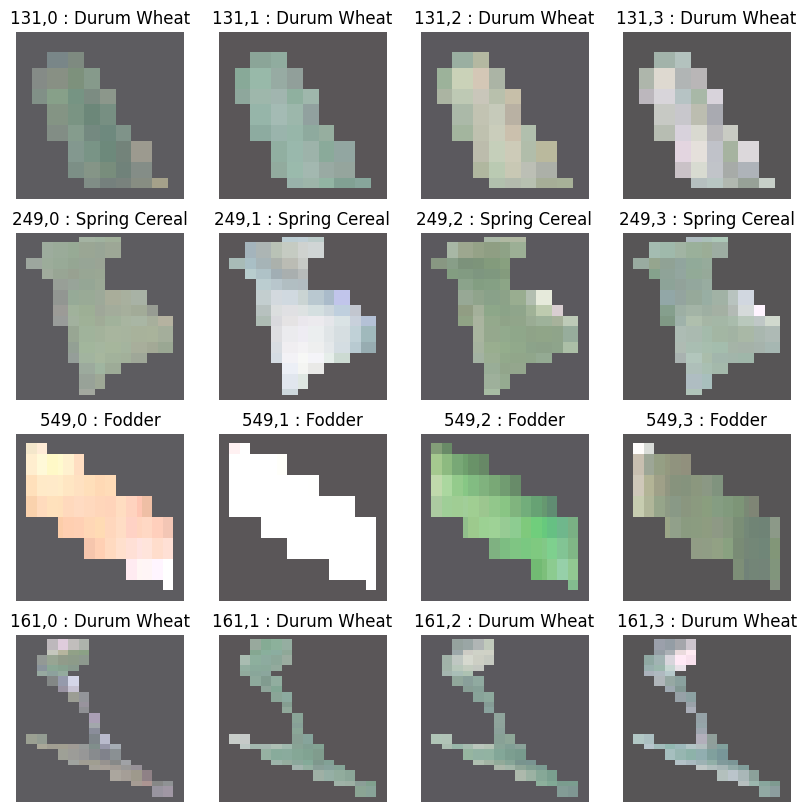

In [ ]:
#functions used for visualization
def view_single_patch(patch, t, ax):
  """
  show a single patch from a sits during season t
  INPUT:
  patch (CxWxH array): the patch to visualize
  t (int): index of the season (fall, winter, spring, summer)
  ax (subplot axis): in which windows to represent the patch
  """
  dates  = [0,6,12,18]
  patch = np.swapaxes(patch[dates[t], [2,1,0],:,:],0,-1)
  patch = np.minimum(1,np.maximum(0,(patch+2)/4))
  ax.imshow(patch)
  plt.axis('off')

def show_random_sits(num_sits, train = True):
  """ show random sits at 4 dates
  INPUT:
  num_sits (int): the number of patches to show
  train (bool): if true loads from the train set, otherwise the test set
  """
  n_row = int(4) #4 columns
  fig = plt.figure(figsize=(10, n_row * 2.5))
  for i_image in range(num_sits):
    index = np.random.randint(n_train) if train else np.random.randint(n_test)
    patch, label = sits_loader(index, train = train)
    for t in range(4):
      ax = fig.add_subplot(n_row, 4, 4*i_image+t+1, aspect='equal')
      view_single_patch(patch, t, ax)
      ax.set_title(str(str(index)) + ',' + str(t) + " : " + class_names[label])

show_random_sits(4, train=False)

## 1.6 Evaluation Metrics

We use the standard evaluation metrics implemented in the previous TDs.

In [ ]:
class ConfusionMatrix:
  def __init__(self, n_class, class_names):
    self.CM = np.zeros((n_class, n_class)) #the matrix itself
    self.n_class = n_class
    self.class_names = class_names

  def add_batch(self, gt, pred):
    #add in the CM a batch of prediction and associated ground truth
    self.CM +=  confusion_matrix(gt, pred, labels = list(range(self.n_class)))

  def overall_accuracy(self):#percentage of correct classification
    return 100 * np.trace(self.CM) / self.CM.sum()

  def class_IoU(self, show = 0):#IoU for each class
    ious = np.diag(self.CM) / (self.CM.sum(0) + self.CM.sum(1) - np.diag(self.CM))

    if show: #print detailed values
      print('\n'.join('{:13s} : {:3.0f}%'.format(name, 100*iou) for name, iou in zip(self.class_names,ious)))
    #do not count classes that are not present in the dataset in the mean IoU
    return 100*np.nansum(ious) / (np.logical_not(np.isnan(ious))).sum()

## 1.7 Training Loop

We use the standard training loop implemented in the previous TDs.

In [ ]:
def train(model, optimizer, loader, args):
  """train for one epoch
  INPUT:
  model = current model
  optimizer = current optimizer
  loader = dataset constituting the epoch
  OUTPUT:
  cm = the confusion matrix over the entire epoch
  lm = the average loss
  """
  model.train() #switch the model in training mode

  #tqdm will provide some nice progress bars
  loader = tqdm(loader, ncols=500, leave=False, desc="Train Epoch")

  #will keep track of the loss
  loss_meter = tnt.meter.AverageValueMeter()
  #keep tracks of prediction errors
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  #goes through the entire dataset
  for index, (tiles, label) in enumerate(loader):

    if model.is_cuda: #put label on GPU
      label = label.cuda()

    optimizer.zero_grad() #put gradient to zero

    pred = model(tiles) #compute the prediction

    loss = nn.functional.cross_entropy(pred,label.squeeze()) #compute the loss

    loss.backward() #compute gradients

    optimizer.step() #one gradient descent step

    #add the loss to the meter
    loss_meter.add(loss.item())
    #fill the confusion matrix
    cm.add_batch(label.cpu().detach().numpy(), pred.argmax(1).view(-1).cpu().detach().numpy())

  return cm, loss_meter.value()[0]

def eval(model, loader, args):
  """
  classify the given dataset. DO NOT track gradients
  INPUT:
  model = model to evaluate
  loader = dataset to classify
  OUTPUT:
  cm = the confusion matrix over the entire dataset
  lm = the average loss
  """

  model.eval() #switch in eval mode

  loader = tqdm(loader, ncols=500, leave=False, desc="Validation")

  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  with torch.no_grad(): #do not compute gradients (saves memory)
    for index, (tiles, label) in enumerate(loader):

      if model.is_cuda: #put label on GPU
        label = label.cuda()

      pred = model(tiles) #compute the prediction

      loss = nn.functional.cross_entropy(pred,label.squeeze()) #compute the loss

      #add the loss to the meter
      loss_meter.add(loss.item())
      #fill the confusion matrix
      cm.add_batch(label.cpu().detach().numpy(), pred.argmax(1).view(-1).cpu().detach().numpy())

  return cm, loss_meter.value()[0]


def train_full(model, args):
  """The full training loop"""

  best_miou = 0

  #create train, val, and test dataset with ListDataset
  train_limit = int(0.8 * n_train) #before this index: train. After this idnex: val
  train_set = tnt.dataset.ListDataset(list(range(train_limit)),partial(sits_loader, train=True))
  val_set = tnt.dataset.ListDataset(list(range(train_limit,n_train)),partial(sits_loader, train=True))
  test_set  = tnt.dataset.ListDataset(list(range(n_test)),partial(sits_loader, train=False))

  #the loader function will take care of the batching
  train_loader = torch.utils.data.DataLoader(train_set, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)
  val_loader = torch.utils.data.DataLoader(val_set, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)
  test_loader = torch.utils.data.DataLoader(test_set, \
         batch_size=args.batch_size, shuffle=False, drop_last=False)

  #define the optimizer
  #Adam optimizer is always a good guess for classification tasks
  optimizer = optim.Adam(model.parameters(), lr=args.lr)

  #defines some color for test and train texts
  TESTCOLOR = '\033[104m'
  TRAINCOLOR = '\033[100m'
  VALIDCOLOR = '\033[45m'
  NORMALCOLOR = '\033[0m'

  for i_epoch in tqdm(range(args.n_epoch), desc="Training"):
    #train one epoch
    cm_train, loss_train = train(model, optimizer, train_loader, args)
    tqdm.write(TRAINCOLOR + 'Epoch %3d -> Train Overall Accuracy: %3.1f%% Train mIoU : %3.1f%% Train Loss: %1.4f' % (i_epoch, cm_train.overall_accuracy(), cm_train.class_IoU(), loss_train) + NORMALCOLOR)

    #evalue performance over the validation set
    cm_val, loss_val = eval(model, val_loader, args)
    tqdm.write(VALIDCOLOR + 'Epoch %3d -> Val Overall Accuracy: %3.1f%% Val mIoU : %3.1f%% Val Loss: %1.4f' % (i_epoch, cm_val.overall_accuracy(), cm_val.class_IoU(), loss_val) + NORMALCOLOR)
    miou_val =  cm_val.class_IoU()
    best_val = False

    if miou_val > best_miou:
      best_val = True
      best_miou = miou_val
      best_model = copy.deepcopy(model)
      tqdm.write(VALIDCOLOR + '-> Best performance achieved!' + NORMALCOLOR)
      cm_test, loss_test = eval(model, test_loader, args)
      tqdm.write(TESTCOLOR + 'Epoch %3d -> Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (i_epoch, cm_test.overall_accuracy(), cm_test.class_IoU(), loss_test) + NORMALCOLOR)
      cm_test.class_IoU(show=1)
  return best_model

## Toy Test

We implemented a toy test to check if your model behaves normally before training. It just test the model on a smal batch of two SITS. These kind of tests are very useful to check for bugs!

In [ ]:
def toy_test(model):
  print(model)
  #makes a batch of 2 patches
  patch1, label = sits_loader(0)
  patch2, label = sits_loader(1)
  patches = torch.cat((patch1[None,:],patch2[None,:]),0)
  #classify batch
  pred = model(patches)
  #check the shape of the outcome
  assert(pred.shape == torch.Size([2,8]))

# 2 Spatio-Temporal Architecture

Great! Now we can finally do some actual deep learning.

The data has both a spatial structure (the images) and a temporal structure (the sequence). Each parcel $x_i$ is of size:
$$
T \times C \times X \times Y~,
$$
with $T=24$ the length of sequence, $C=10$ the number of channels, $X=Y=32$ the spatial extent of parcels. Each parcel is associated with a ground truth label within N=8 classes.

The neural architectures must account for both spatial and temporal dimensions. Throughout this TD, we will implement 8 different networks. Some approaches treat the spatial and temporal structure separately, allowing us to associate part of the network to each dimension. We adopt the following naming convention: spatialNetwork_temporalNetwork, eg: `cnn_gru` or `mlp_tae`. Some networks operate jointly on the spatial and temporal structure with the same module. In which case, we name them without `_`, eg: `cnn3D`.

As you complete the questions, fill out the following table with the size of the modules dedicated to each modality, and the performance of the network (in \%, no decimal). Since we want to train many networks, you can report the highest performance on the test set as computed on epochs selected by the validation set, and not necessarily the last one. This is not a very rigorous approach, but will give you an estimate of what a good run can give you. Do not do that in papers! If you want to do it right, train the networks 10 times and report the mean of the last test performance and the devations (but that will take too much time).

All networks should have around 100k parameters and take between 2 to 4 minute to train on a GPU.

<table>
  <tr>
    <th> </th>
    <th> </th>
    <td colspan="3"> &emsp;&emsp;&emsp;&emsp; Model Size</td>
    <td colspan="3">Performance</td>
 </tr>
  <tr>
    <th>Difficulty</th>
    <th>Method</th>
    <th>Spatial</th>
    <th>Temporal</th>
    <th>Classifier</th>
    <th>OA</th>
    <th>mIoU</th>
  </tr>
  <tr>
    <td> $\star$ </td>
    <td>mlp_gru</td>
    <td> 5120 </td>
    <td> 74496 </td>
    <td> 25672 </td>
    <td> 80.2% </td>
    <td> 65.8% </td>
  </tr>
  <tr>
    <td> $\star\star$ </td>
    <td>cnn_max</td>
    <td> 112480 </td>
    <td> 0 </td>
    <td> 25672 </td>
    <td> 67.5% </td>
    <td> 51.4% </td>
  </tr>
  <tr>
    <td> $\star$ </td>
    <td>cnn_gru</td>
    <td> 79680 </td>
    <td> 3195648 </td>
    <td> 1032 </td>
    <td> 12.2% </td>
    <td> 1.5% </td>
  </tr>
    <tr>
    <td> $\star\star$ </td>
    <td>cnn_cnn</td>
    <td> 64008 </td>
    <td> 27936 </td>
    <td> 14648 </td>
    <td> 62.8% </td>
    <td> 45.1% </td>
  </tr>
  <tr>
    <td> $\star\star$ </td>
    <td>convlstm</td>
    <td colspan="2"> &emsp;&emsp; 71040 </td>
    <td> 1076 </td>
    <td> 50.88% </td>
    <td> 33.27% </td>
  </tr>
    <tr>
    <td> $\star\star$ </td>
    <td>3dcnn</td>
    <td colspan="2"> &emsp;&emsp; 72000 </td>
    <td> 3872 </td>
    <td> 69.8% </td>
    <td> 50.9% </td>
  </tr>
    <tr>
    <td> $\star\star\star$ </td>
    <td>mlp_tae</td>
    <td> 39936 </td>
    <td> 47872 </td>
    <td> 56936 </td>
    <td> 79.5% </td>
    <td> 65.5% </td>
  </tr>
  <tr>
    <td> $\star\star$ </td>
    <td>cnn_tae</td>
    <td> 28160 </td>
    <td> 34784 </td>
    <td> 39768 </td>
    <td> 84.0% </td>
    <td> 71.4% </td>
  </tr>
    <tr>
    <td> $\star\star\star$ </td>
    <td>best_design</td>
    <td> 28160 </td>
    <td> 34784 </td>
    <td> 39768 </td>
    <td> 84.0% </td>
    <td> 71.4% </td>
  </tr>
</table>

Each star completed is worth $5$\%, and the response to <font color='red'>questions</font> are worth $20\%$ in total.
Please answer in <font color='cyan'>blue</font>!


## 2.1 Gated Recurrent Unit `mlp_gru`

Our goal is to map a sequence of $T=24$ images of size $C=10\times32\times32$ to a vector of $N=8$ class scores corresponding to the crop classes. We start by implementing a simple approach focusing purely on the temporal structure. We compute the spatial average of each image and process them with an MLP. Then a Gated Recurrent Unit will classify the resulting sequence of embeddings . The network is composed of 3 parts:
- **Spatial Embedding**:  a simple MLP `mlp_spatial`: $C \mapsto E$ maps the vector of spectral averages to a parcel representation of size E=embed_size
- **Gated Recurrent Unit**: a RNN `gru_temporal`: $E\times T \mapsto H$  takes a sequence of representations as input and returns the last hidden state of size H=hidden_size
- **Classification Network**: a simple MLP `classifier`:$H \mapsto N$  maps an input embedding to a vector of class scores of size N=8

The network operates as follows:
- (i)  we compute the spatial average $\{a_t\}_{t=1}^T$ of each parcel and each date
- (ii)  we use `mlp_spatial` to compute the embeddings $\{e_t\}_{t=1}^T$ for all parcels and dates  *simultaneously*
- (iii) process the sequences of embeddings with `gru_temporal`
- (iv) use `classifier` to map the last hidden state to the class prediction

\begin{align}
     a_i  &=  \text{mean}_{X,Y}(x_t) \; \text{for}\; t=1 \cdots T & (i)\\
     e_i  &=  \text{mlp_spatial}(a_t) \; \text{for}\; t=1 \cdots T & (ii)\\
     h  &=  \text{gru_temporal}([e_1, \cdots e_T]) & (iii)\\
     y  &= \text{classifier}(h) & (iv)
\end{align}

Q2) Complete the following function, run the tests, and train a model. Fill out the table above with the performance.

In [ ]:
class MLP_GRU(nn.Module):
  """
  MLP GRU for classifying a sequence of parcel observations
  """

  def __init__(self, n_channels, embed_size, hidden_size,  n_class, cuda=1):
    """
    initialization function
    n_channels (int): number of input channel (C)
    embed_size (int): size of parcel embeddings (E)
    hidden_size (int):  width of the hidden layer of the GRU (H)
    n_class (int): number of classes (N)
    """
    super(MLP_GRU, self).__init__() #necessary for all classes extending the module class

    self.is_cuda = cuda
    self.embed_size = embed_size

    self.mlp_spatial = nn.Sequential( #2 layers MLP : n_channels->embed_size->embed_size
      nn.Linear(n_channels, embed_size),
      nn.BatchNorm1d(embed_size),
      nn.ReLU(),
      nn.Linear(embed_size, embed_size),
      nn.BatchNorm1d(embed_size),
      nn.ReLU(),
    )

    self.gru_temporal = nn.GRU(input_size=embed_size, hidden_size=hidden_size,
                      num_layers=1,batch_first=True)

    self.classifier = nn.Sequential(#2 layers MLP : hidden_size->hidden_size//2->n_class
      nn.Linear(hidden_size, hidden_size),  #Fixed: Added nn.Linear
      nn.BatchNorm1d(hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size//2),
      nn.BatchNorm1d(hidden_size//2),
      nn.ReLU(),
      nn.Linear(hidden_size//2, n_class) #Fixed: Added nn.Linear and n_class
      #/!\ no activation nor batchnorm on the last layer!
      #Predicitons are logits and should not be normalized
    )

    if cuda: #put the model on the GPU memory
      self.cuda()

  def forward(self,x):
    """
    the foward pass : maps input to output
    x is of size B x T x C x X x Y
    """
    if self.is_cuda: #input to the GPU at the last second to save some VRAM
      x = x.cuda()
    B,T,C,X,Y = x.shape

    #spatial average
    a = x.mean(axis=(3,4))  #BxTxCxXxY -> BxTxC
    #we use the batch dimension to embed all parcels at the same time for speed!
    #BxTxC --reshape1--> (B*T)xC --mlp_spatial--> (B*T)xE --reshape2--> BxTxE
    #make sure that you understand this next line well as we wil re-use this trick everywhere
    e = self.mlp_spatial(a.reshape((B*T,C))).reshape((B,T,self.embed_size))
    #GRU returns sequence of h (we don't need it) and last h
    _, h = self.gru_temporal(e) #BxTxE -> BxEx1
    return self.classifier(h.squeeze()) #squeeze removes unused dimensions, BxEx1--squeeze--> BxE --classifier--> BxK

toy_test(MLP_GRU(10,64,128,8, cuda=torch.cuda.is_available()))

MLP_GRU(
  (mlp_spatial): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (gru_temporal): GRU(64, 128, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=8, bias=True)
  )
)


In [ ]:
args = mock.Mock() #stores the parameters
args.n_epoch = 30 #number of epochs
args.batch_size = 16 #size of batch
args.n_channel = 10 #number of channels
args.embed_size = 64 #size of parcel embedding
args.hidden_size = 128 #size of hidden state H
args.n_class = 8 #number of classes N
args.cuda = torch.cuda.is_available() #1: use the GPU, 0: use CPU (slow!)
args.lr = 5e-3 #learning rate

#create the model to train
mlp_gru = MLP_GRU(args.n_channel, args.embed_size, args.hidden_size,
                  args.n_class, args.cuda)
print(mlp_gru)
print('Total number of parameters: {}'.format(sum([p.numel() for p in mlp_gru.parameters()])))
print('Parameters in spatial module: {}'.format(sum([p.numel() for p in mlp_gru.mlp_spatial.parameters()])))
print('Parameters in temporal module: {}'.format(sum([p.numel() for p in mlp_gru.gru_temporal.parameters()])))
print('Parameters in classifier module: {}'.format(sum([p.numel() for p in mlp_gru.classifier.parameters()])))

#train the model
trained_mlp_gru = train_full(mlp_gru, args)

MLP_GRU(
  (mlp_spatial): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (gru_temporal): GRU(64, 128, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=8, bias=True)
  )
)
Total number of parameters: 105288
Parameters in spatial module: 5120
Parameters in temporal module: 74496
Parameters in classifier module: 25672


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch:   0%|                                                                                            …

Epoch   0 -> Train Overall Accuracy: 47.9% Train mIoU : 28.4% Train Loss: 1.3709


Validation:   0%|                                                                                             …

Epoch   0 -> Val Overall Accuracy: 59.8% Val mIoU : 37.1% Val Loss: 1.0420
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   0 -> Test Overall Accuracy: 53.38% Test mIoU : 33.25%  Test Loss: 1.1753
Meadow        :  60%
Durum Wheat   :  37%
Spring Cereal :  13%
Sorgho        :   5%
Leguminous    :  53%
Fodder        :  34%
Ligneous      :  61%
Grapevine     :   4%


Train Epoch:   0%|                                                                                            …

Epoch   1 -> Train Overall Accuracy: 61.3% Train mIoU : 42.0% Train Loss: 1.0566


Validation:   0%|                                                                                             …

Epoch   1 -> Val Overall Accuracy: 66.2% Val mIoU : 47.0% Val Loss: 0.9409
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   1 -> Test Overall Accuracy: 62.50% Test mIoU : 44.91%  Test Loss: 1.0849
Meadow        :  71%
Durum Wheat   :  41%
Spring Cereal :  44%
Sorgho        :  35%
Leguminous    :  52%
Fodder        :  30%
Ligneous      :  72%
Grapevine     :  16%


Train Epoch:   0%|                                                                                            …

Epoch   2 -> Train Overall Accuracy: 62.5% Train mIoU : 43.9% Train Loss: 1.0308


Validation:   0%|                                                                                             …

Epoch   2 -> Val Overall Accuracy: 67.8% Val mIoU : 51.1% Val Loss: 0.8764
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   2 -> Test Overall Accuracy: 66.00% Test mIoU : 50.02%  Test Loss: 0.9404
Meadow        :  66%
Durum Wheat   :  37%
Spring Cereal :  42%
Sorgho        :  40%
Leguminous    :  78%
Fodder        :  59%
Ligneous      :  65%
Grapevine     :  14%


Train Epoch:   0%|                                                                                            …

Epoch   3 -> Train Overall Accuracy: 66.3% Train mIoU : 48.9% Train Loss: 0.8894


Validation:   0%|                                                                                             …

Epoch   3 -> Val Overall Accuracy: 67.0% Val mIoU : 46.4% Val Loss: 0.8840


Train Epoch:   0%|                                                                                            …

Epoch   4 -> Train Overall Accuracy: 67.2% Train mIoU : 49.6% Train Loss: 0.9105


Validation:   0%|                                                                                             …

Epoch   4 -> Val Overall Accuracy: 72.8% Val mIoU : 55.5% Val Loss: 0.8225
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   4 -> Test Overall Accuracy: 66.62% Test mIoU : 51.30%  Test Loss: 0.8871
Meadow        :  65%
Durum Wheat   :  42%
Spring Cereal :  51%
Sorgho        :  23%
Leguminous    :  84%
Fodder        :  59%
Ligneous      :  65%
Grapevine     :  21%


Train Epoch:   0%|                                                                                            …

Epoch   5 -> Train Overall Accuracy: 70.4% Train mIoU : 53.7% Train Loss: 0.8590


Validation:   0%|                                                                                             …

Epoch   5 -> Val Overall Accuracy: 71.8% Val mIoU : 52.4% Val Loss: 0.7888


Train Epoch:   0%|                                                                                            …

Epoch   6 -> Train Overall Accuracy: 70.5% Train mIoU : 54.3% Train Loss: 0.8113


Validation:   0%|                                                                                             …

Epoch   6 -> Val Overall Accuracy: 70.0% Val mIoU : 51.8% Val Loss: 0.8476


Train Epoch:   0%|                                                                                            …

Epoch   7 -> Train Overall Accuracy: 69.6% Train mIoU : 52.9% Train Loss: 0.8412


Validation:   0%|                                                                                             …

Epoch   7 -> Val Overall Accuracy: 73.2% Val mIoU : 56.0% Val Loss: 0.7611
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   7 -> Test Overall Accuracy: 69.00% Test mIoU : 52.92%  Test Loss: 0.8657
Meadow        :  66%
Durum Wheat   :  40%
Spring Cereal :  56%
Sorgho        :  36%
Leguminous    :  70%
Fodder        :  55%
Ligneous      :  77%
Grapevine     :  24%


Train Epoch:   0%|                                                                                            …

Epoch   8 -> Train Overall Accuracy: 72.3% Train mIoU : 56.3% Train Loss: 0.7752


Validation:   0%|                                                                                             …

Epoch   8 -> Val Overall Accuracy: 76.0% Val mIoU : 60.4% Val Loss: 0.6765
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   8 -> Test Overall Accuracy: 68.75% Test mIoU : 53.09%  Test Loss: 0.8256
Meadow        :  66%
Durum Wheat   :  45%
Spring Cereal :  51%
Sorgho        :  43%
Leguminous    :  67%
Fodder        :  57%
Ligneous      :  74%
Grapevine     :  22%


Train Epoch:   0%|                                                                                            …

Epoch   9 -> Train Overall Accuracy: 71.6% Train mIoU : 55.7% Train Loss: 0.7692


Validation:   0%|                                                                                             …

Epoch   9 -> Val Overall Accuracy: 70.5% Val mIoU : 55.2% Val Loss: 0.7563


Train Epoch:   0%|                                                                                            …

Epoch  10 -> Train Overall Accuracy: 73.4% Train mIoU : 58.4% Train Loss: 0.7434


Validation:   0%|                                                                                             …

Epoch  10 -> Val Overall Accuracy: 74.5% Val mIoU : 57.3% Val Loss: 0.7616


Train Epoch:   0%|                                                                                            …

Epoch  11 -> Train Overall Accuracy: 74.4% Train mIoU : 59.1% Train Loss: 0.7042


Validation:   0%|                                                                                             …

Epoch  11 -> Val Overall Accuracy: 76.8% Val mIoU : 61.2% Val Loss: 0.6836
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  11 -> Test Overall Accuracy: 74.00% Test mIoU : 60.05%  Test Loss: 0.7738
Meadow        :  80%
Durum Wheat   :  44%
Spring Cereal :  62%
Sorgho        :  37%
Leguminous    :  79%
Fodder        :  68%
Ligneous      :  75%
Grapevine     :  36%


Train Epoch:   0%|                                                                                            …

Epoch  12 -> Train Overall Accuracy: 74.9% Train mIoU : 59.9% Train Loss: 0.7025


Validation:   0%|                                                                                             …

Epoch  12 -> Val Overall Accuracy: 76.8% Val mIoU : 60.9% Val Loss: 0.6986


Train Epoch:   0%|                                                                                            …

Epoch  13 -> Train Overall Accuracy: 74.9% Train mIoU : 59.7% Train Loss: 0.7052


Validation:   0%|                                                                                             …

Epoch  13 -> Val Overall Accuracy: 75.5% Val mIoU : 59.0% Val Loss: 0.6502


Train Epoch:   0%|                                                                                            …

Epoch  14 -> Train Overall Accuracy: 76.4% Train mIoU : 62.0% Train Loss: 0.6619


Validation:   0%|                                                                                             …

Epoch  14 -> Val Overall Accuracy: 79.2% Val mIoU : 65.3% Val Loss: 0.6415
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  14 -> Test Overall Accuracy: 76.00% Test mIoU : 62.57%  Test Loss: 0.7351
Meadow        :  83%
Durum Wheat   :  44%
Spring Cereal :  61%
Sorgho        :  51%
Leguminous    :  73%
Fodder        :  67%
Ligneous      :  81%
Grapevine     :  41%


Train Epoch:   0%|                                                                                            …

Epoch  15 -> Train Overall Accuracy: 77.3% Train mIoU : 62.9% Train Loss: 0.6174


Validation:   0%|                                                                                             …

Epoch  15 -> Val Overall Accuracy: 75.8% Val mIoU : 58.7% Val Loss: 0.7623


Train Epoch:   0%|                                                                                            …

Epoch  16 -> Train Overall Accuracy: 77.3% Train mIoU : 62.6% Train Loss: 0.6417


Validation:   0%|                                                                                             …

Epoch  16 -> Val Overall Accuracy: 74.0% Val mIoU : 57.3% Val Loss: 0.7501


Train Epoch:   0%|                                                                                            …

Epoch  17 -> Train Overall Accuracy: 77.2% Train mIoU : 63.1% Train Loss: 0.6541


Validation:   0%|                                                                                             …

Epoch  17 -> Val Overall Accuracy: 77.0% Val mIoU : 60.9% Val Loss: 0.6664


Train Epoch:   0%|                                                                                            …

Epoch  18 -> Train Overall Accuracy: 77.6% Train mIoU : 63.7% Train Loss: 0.6369


Validation:   0%|                                                                                             …

Epoch  18 -> Val Overall Accuracy: 78.0% Val mIoU : 62.4% Val Loss: 0.6232


Train Epoch:   0%|                                                                                            …

Epoch  19 -> Train Overall Accuracy: 78.3% Train mIoU : 64.7% Train Loss: 0.6182


Validation:   0%|                                                                                             …

Epoch  19 -> Val Overall Accuracy: 76.8% Val mIoU : 61.1% Val Loss: 0.6717


Train Epoch:   0%|                                                                                            …

Epoch  20 -> Train Overall Accuracy: 78.3% Train mIoU : 64.8% Train Loss: 0.6063


Validation:   0%|                                                                                             …

Epoch  20 -> Val Overall Accuracy: 77.0% Val mIoU : 62.6% Val Loss: 0.6666


Train Epoch:   0%|                                                                                            …

Epoch  21 -> Train Overall Accuracy: 81.4% Train mIoU : 68.8% Train Loss: 0.5629


Validation:   0%|                                                                                             …

Epoch  21 -> Val Overall Accuracy: 81.0% Val mIoU : 67.7% Val Loss: 0.5755
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  21 -> Test Overall Accuracy: 74.75% Test mIoU : 60.90%  Test Loss: 0.7304
Meadow        :  73%
Durum Wheat   :  39%
Spring Cereal :  64%
Sorgho        :  47%
Leguminous    :  80%
Fodder        :  65%
Ligneous      :  84%
Grapevine     :  35%


Train Epoch:   0%|                                                                                            …

Epoch  22 -> Train Overall Accuracy: 81.9% Train mIoU : 69.7% Train Loss: 0.5261


Validation:   0%|                                                                                             …

Epoch  22 -> Val Overall Accuracy: 79.2% Val mIoU : 65.4% Val Loss: 0.6069


Train Epoch:   0%|                                                                                            …

Epoch  23 -> Train Overall Accuracy: 80.7% Train mIoU : 68.1% Train Loss: 0.5357


Validation:   0%|                                                                                             …

Epoch  23 -> Val Overall Accuracy: 76.8% Val mIoU : 60.6% Val Loss: 0.6343


Train Epoch:   0%|                                                                                            …

Epoch  24 -> Train Overall Accuracy: 81.7% Train mIoU : 69.7% Train Loss: 0.5162


Validation:   0%|                                                                                             …

Epoch  24 -> Val Overall Accuracy: 76.0% Val mIoU : 60.3% Val Loss: 0.6609


Train Epoch:   0%|                                                                                            …

Epoch  25 -> Train Overall Accuracy: 79.4% Train mIoU : 65.8% Train Loss: 0.5584


Validation:   0%|                                                                                             …

Epoch  25 -> Val Overall Accuracy: 77.5% Val mIoU : 62.3% Val Loss: 0.6460


Train Epoch:   0%|                                                                                            …

Epoch  26 -> Train Overall Accuracy: 79.8% Train mIoU : 66.3% Train Loss: 0.5656


Validation:   0%|                                                                                             …

Epoch  26 -> Val Overall Accuracy: 76.0% Val mIoU : 58.5% Val Loss: 0.7617


Train Epoch:   0%|                                                                                            …

Epoch  27 -> Train Overall Accuracy: 81.4% Train mIoU : 68.7% Train Loss: 0.5277


Validation:   0%|                                                                                             …

Epoch  27 -> Val Overall Accuracy: 74.8% Val mIoU : 57.3% Val Loss: 0.6737


Train Epoch:   0%|                                                                                            …

Epoch  28 -> Train Overall Accuracy: 80.9% Train mIoU : 68.4% Train Loss: 0.5298


Validation:   0%|                                                                                             …

Epoch  28 -> Val Overall Accuracy: 79.0% Val mIoU : 64.8% Val Loss: 0.6615


Train Epoch:   0%|                                                                                            …

Epoch  29 -> Train Overall Accuracy: 80.7% Train mIoU : 67.8% Train Loss: 0.5315


Validation:   0%|                                                                                             …

Epoch  29 -> Val Overall Accuracy: 80.2% Val mIoU : 65.8% Val Loss: 0.6105


## 2.2 Spatial CNN `cnn_max`

We now implement a purely spatial baseline method. We use a CNN to compute a spatial embeddings of all dates, and temporaly pool the resulting embeddings to collapse the temporal dimension. This network has two parts:
- **Spatial Embedding**:  a CNN `cnn_spatial`: $C \times X \times Y \mapsto E$  maps the images to an embedding of size E=embed_size
- **Classification Network**: a simple MLP `classifier`: $E \mapsto N$ maps the embedding to a vector of class scores of size N=8

The network operates as follows:
- (i)  we use `cnn_spatial` to compute spatial embeddings $\{e_t\}_{t=1}^T$ of all parcels at all dates *simultaneously*
- (ii)  we use a temporal pooling operation (here, max) to compute a single embedding for the sequence
- (iii) use `classifier` to map this embedding to the class prediction

\begin{align}
     e_t  &=  \text{cnn}(x_t) \; \text{for}\; t=1 \cdots T & (i)\\
     E  &=  \text{max}_T([e_1, \cdots e_T])  & (ii)\\
     y  &= \text{classifier}(E)  & (iii)
\end{align}

Q3) Complete the following cell, run the test and the training.

In [ ]:
class CNN_MAX(nn.Module):
  """
  Simple CNN baseline for classifying a sequence of images
  """

  def __init__(self, n_channels, embed_size, n_class, cuda=1):
    """
    initialization function
    n_channels (int): number of input channel
    embed_size (int): size of parcel embeddings
    n_class (int): number of classes
    """
    super(CNN_MAX, self).__init__() #necessary for all classes extending the module class

    self.is_cuda = cuda
    self.embed_size = embed_size

    #CNN:
    #n_channels--Conv2D(3,3)-->embed_size//4 -> maxpool(2)
    #embed_size//4--Conv2D(3,3)-->embed_size//2 -> maxpool(2)
    #embed_size//2--Conv2D(3,3)-->embed_size -> maxpool(4)
    #embed_size--Conv2D(1,1)-->embed_size
    self.cnn_spatial = nn.Sequential(
      nn.Conv2d(in_channels=n_channels, out_channels=embed_size//4 , kernel_size=3), \
      nn.BatchNorm2d(num_features=embed_size//4), \
      nn.ReLU(True),
      nn.MaxPool2d(2),
      nn.Conv2d(in_channels=embed_size//4, out_channels=embed_size//2 , kernel_size=3), \
      nn.BatchNorm2d(num_features=embed_size//2), \
      nn.ReLU(True),
      nn.MaxPool2d(2),
      nn.Conv2d(in_channels=embed_size//2, out_channels=embed_size , kernel_size=3), \
      nn.BatchNorm2d(num_features=embed_size), \
      nn.ReLU(True),
      nn.MaxPool2d(4),
      nn.Conv2d(in_channels=embed_size, out_channels=embed_size , kernel_size=1), \
      nn.BatchNorm2d(num_features=embed_size), \
      nn.ReLU(True))
class CNN_MAX(nn.Module):
  """
  Simple CNN baseline for classifying a sequence of images
  """

  def __init__(self, n_channels, embed_size, n_class, cuda=1):
    """
    initialization function
    n_channels (int): number of input channel
    embed_size (int): size of parcel embeddings
    n_class (int): number of classes
    """
    super(CNN_MAX, self).__init__() #necessary for all classes extending the module class

    self.is_cuda = cuda
    self.embed_size = embed_size

    #CNN:
    #n_channels--Conv2D(3,3)-->embed_size//4 -> maxpool(2)
    #embed_size//4--Conv2D(3,3)-->embed_size//2 -> maxpool(2)
    #embed_size//2--Conv2D(3,3)-->embed_size -> maxpool(4)
    #embed_size--Conv2D(1,1)-->embed_size
    self.cnn_spatial = nn.Sequential(
      nn.Conv2d(in_channels=n_channels, out_channels=embed_size//4 , kernel_size=3),
      nn.BatchNorm2d(num_features=embed_size//4),
      nn.ReLU(True),
      nn.MaxPool2d(2),
      nn.Conv2d(in_channels=embed_size//4, out_channels=embed_size//2 , kernel_size=3),
      nn.BatchNorm2d(num_features=embed_size//2),
      nn.ReLU(True),
      nn.MaxPool2d(2),
      nn.Conv2d(in_channels=embed_size//2, out_channels=embed_size , kernel_size=3),
      nn.BatchNorm2d(num_features=embed_size),
      nn.ReLU(True),
      nn.MaxPool2d(4),
      nn.Conv2d(in_channels=embed_size, out_channels=embed_size , kernel_size=1),
      nn.BatchNorm2d(num_features=embed_size),
      nn.ReLU(True)
    )

    self.classifier = nn.Sequential( #same classifier MLP as mlp_gru
      nn.Linear(embed_size, embed_size),
      nn.BatchNorm1d(embed_size),
      nn.ReLU(),
      nn.Linear(embed_size, embed_size//2), #Added this layer to match the previous architecture with the expected output size in toy_test.
      nn.BatchNorm1d(embed_size//2),
      nn.ReLU(),
      nn.Linear(embed_size//2,8) #Added this layer to match the previous architecture with the expected output size in toy_test.

    )

    if cuda: #put the model on the GPU memory
      self.cuda()

  def forward(self,x):
    """
    the foward pass : maps input to output
    x is of size B x T x C x X x Y
    """
    if self.is_cuda: #input to the GPU at the last second to save some VRAM
      x = x.cuda()
    B,T,C,X,Y = x.shape

    #we use the batch dimension to embed all parcels at the same time
    #BxTxCxXxY --reshape1--> (B*T)xCxXxY --cnn_spatial--> (B*T)xE --reshape2--> BxTxE
    e = self.cnn_spatial(x.reshape((B*T,C,X,Y))).reshape((B,T,self.embed_size))
    #added a view call to match the expexted shape of the classifier
    E = e.amax(dim=1).squeeze().view(B,self.embed_size) #BxTxE --amax--> Bx1xE --squeeze--> BxE
    return self.classifier(E) # BxE --classifier--> BxK

toy_test(CNN_MAX(10,64,8, cuda=torch.cuda.is_available()))

CNN_MAX(
  (cnn_spatial): Sequential(
    (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
 

In [ ]:
args = mock.Mock() #stores the parameters
args.n_epoch = 30 #number of epochs
args.batch_size = 16 #size of batch
args.n_channel = 10 #number of channels
args.embed_size = 128 #size of parcel embedding
args.n_class = 8 #number of classes
args.cuda = torch.cuda.is_available() #1: use the GPU, 0: use CPU (slow!)
args.lr = 5e-3 #learning rate

#create the model to train
cnn_max = CNN_MAX(args.n_channel, args.embed_size, args.n_class, args.cuda)
print(cnn_max)
print('Total number of parameters: {}'.format(sum([p.numel() for p in cnn_max.parameters()])))
print('Parameters in spatial module: {}'.format(sum([p.numel() for p in cnn_max.cnn_spatial.parameters()])))
print('Parameters in classifier module: {}'.format(sum([p.numel() for p in cnn_max.classifier.parameters()])))

#train the model
trained_cnn_max = train_full(cnn_max, args)

CNN_MAX(
  (cnn_spatial): Sequential(
    (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=Tr

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch:   0%|                                                                                            …

Epoch   0 -> Train Overall Accuracy: 44.9% Train mIoU : 27.3% Train Loss: 1.4608


Validation:   0%|                                                                                             …

Epoch   0 -> Val Overall Accuracy: 50.0% Val mIoU : 28.5% Val Loss: 1.3518
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   0 -> Test Overall Accuracy: 44.75% Test mIoU : 25.69%  Test Loss: 1.4429
Meadow        :  64%
Durum Wheat   :  32%
Spring Cereal :  15%
Sorgho        :  13%
Leguminous    :  33%
Fodder        :   0%
Ligneous      :  46%
Grapevine     :   3%


Train Epoch:   0%|                                                                                            …

Epoch   1 -> Train Overall Accuracy: 53.8% Train mIoU : 35.2% Train Loss: 1.2446


Validation:   0%|                                                                                             …

Epoch   1 -> Val Overall Accuracy: 54.0% Val mIoU : 34.6% Val Loss: 1.2018
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   1 -> Test Overall Accuracy: 54.62% Test mIoU : 35.91%  Test Loss: 1.2799
Meadow        :  69%
Durum Wheat   :  39%
Spring Cereal :  15%
Sorgho        :  25%
Leguminous    :  53%
Fodder        :  34%
Ligneous      :  47%
Grapevine     :   7%


Train Epoch:   0%|                                                                                            …

Epoch   2 -> Train Overall Accuracy: 60.4% Train mIoU : 41.7% Train Loss: 1.0845


Validation:   0%|                                                                                             …

Epoch   2 -> Val Overall Accuracy: 62.0% Val mIoU : 42.8% Val Loss: 1.0049
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   2 -> Test Overall Accuracy: 58.25% Test mIoU : 40.43%  Test Loss: 1.0867
Meadow        :  72%
Durum Wheat   :  38%
Spring Cereal :  25%
Sorgho        :  27%
Leguminous    :  58%
Fodder        :  35%
Ligneous      :  46%
Grapevine     :  22%


Train Epoch:   0%|                                                                                            …

Epoch   3 -> Train Overall Accuracy: 60.9% Train mIoU : 42.2% Train Loss: 1.0651


Validation:   0%|                                                                                             …

Epoch   3 -> Val Overall Accuracy: 64.8% Val mIoU : 43.5% Val Loss: 0.9408
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   3 -> Test Overall Accuracy: 62.88% Test mIoU : 44.04%  Test Loss: 1.0755
Meadow        :  76%
Durum Wheat   :  40%
Spring Cereal :  47%
Sorgho        :   1%
Leguminous    :  62%
Fodder        :  48%
Ligneous      :  57%
Grapevine     :  21%


Train Epoch:   0%|                                                                                            …

Epoch   4 -> Train Overall Accuracy: 65.4% Train mIoU : 47.4% Train Loss: 0.9670


Validation:   0%|                                                                                             …

Epoch   4 -> Val Overall Accuracy: 57.2% Val mIoU : 38.1% Val Loss: 1.1197


Train Epoch:   0%|                                                                                            …

Epoch   5 -> Train Overall Accuracy: 66.4% Train mIoU : 48.4% Train Loss: 0.9426


Validation:   0%|                                                                                             …

Epoch   5 -> Val Overall Accuracy: 70.8% Val mIoU : 53.2% Val Loss: 0.8570
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   5 -> Test Overall Accuracy: 66.50% Test mIoU : 49.89%  Test Loss: 0.9450
Meadow        :  72%
Durum Wheat   :  42%
Spring Cereal :  57%
Sorgho        :  23%
Leguminous    :  74%
Fodder        :  56%
Ligneous      :  53%
Grapevine     :  22%


Train Epoch:   0%|                                                                                            …

Epoch   6 -> Train Overall Accuracy: 65.5% Train mIoU : 47.9% Train Loss: 0.9289


Validation:   0%|                                                                                             …

Epoch   6 -> Val Overall Accuracy: 54.8% Val mIoU : 36.8% Val Loss: 1.2911


Train Epoch:   0%|                                                                                            …

Epoch   7 -> Train Overall Accuracy: 69.1% Train mIoU : 51.7% Train Loss: 0.8676


Validation:   0%|                                                                                             …

Epoch   7 -> Val Overall Accuracy: 67.2% Val mIoU : 50.3% Val Loss: 0.9699


Train Epoch:   0%|                                                                                            …

Epoch   8 -> Train Overall Accuracy: 69.4% Train mIoU : 52.4% Train Loss: 0.8354


Validation:   0%|                                                                                             …

Epoch   8 -> Val Overall Accuracy: 67.8% Val mIoU : 49.0% Val Loss: 0.8490


Train Epoch:   0%|                                                                                            …

Epoch   9 -> Train Overall Accuracy: 72.1% Train mIoU : 55.8% Train Loss: 0.7848


Validation:   0%|                                                                                             …

Epoch   9 -> Val Overall Accuracy: 69.0% Val mIoU : 51.7% Val Loss: 0.7968


Train Epoch:   0%|                                                                                            …

Epoch  10 -> Train Overall Accuracy: 71.2% Train mIoU : 54.8% Train Loss: 0.8023


Validation:   0%|                                                                                             …

Epoch  10 -> Val Overall Accuracy: 64.5% Val mIoU : 47.3% Val Loss: 0.9707


Train Epoch:   0%|                                                                                            …

Epoch  11 -> Train Overall Accuracy: 73.1% Train mIoU : 56.9% Train Loss: 0.7536


Validation:   0%|                                                                                             …

Epoch  11 -> Val Overall Accuracy: 51.5% Val mIoU : 32.3% Val Loss: 1.3506


Train Epoch:   0%|                                                                                            …

Epoch  12 -> Train Overall Accuracy: 74.3% Train mIoU : 58.0% Train Loss: 0.7054


Validation:   0%|                                                                                             …

Epoch  12 -> Val Overall Accuracy: 68.8% Val mIoU : 51.9% Val Loss: 0.8035


Train Epoch:   0%|                                                                                            …

Epoch  13 -> Train Overall Accuracy: 76.1% Train mIoU : 61.0% Train Loss: 0.6902


Validation:   0%|                                                                                             …

Epoch  13 -> Val Overall Accuracy: 74.5% Val mIoU : 57.7% Val Loss: 0.7653
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  13 -> Test Overall Accuracy: 70.88% Test mIoU : 54.95%  Test Loss: 0.8857
Meadow        :  81%
Durum Wheat   :  39%
Spring Cereal :  61%
Sorgho        :  39%
Leguminous    :  73%
Fodder        :  58%
Ligneous      :  58%
Grapevine     :  31%


Train Epoch:   0%|                                                                                            …

Epoch  14 -> Train Overall Accuracy: 77.0% Train mIoU : 62.0% Train Loss: 0.6236


Validation:   0%|                                                                                             …

Epoch  14 -> Val Overall Accuracy: 68.0% Val mIoU : 51.1% Val Loss: 0.8661


Train Epoch:   0%|                                                                                            …

Epoch  15 -> Train Overall Accuracy: 76.2% Train mIoU : 61.2% Train Loss: 0.6600


Validation:   0%|                                                                                             …

Epoch  15 -> Val Overall Accuracy: 70.2% Val mIoU : 53.4% Val Loss: 0.9032


Train Epoch:   0%|                                                                                            …

Epoch  16 -> Train Overall Accuracy: 76.8% Train mIoU : 61.9% Train Loss: 0.6642


Validation:   0%|                                                                                             …

Epoch  16 -> Val Overall Accuracy: 53.5% Val mIoU : 37.2% Val Loss: 1.5467


Train Epoch:   0%|                                                                                            …

Epoch  17 -> Train Overall Accuracy: 77.9% Train mIoU : 63.2% Train Loss: 0.5953


Validation:   0%|                                                                                             …

Epoch  17 -> Val Overall Accuracy: 71.0% Val mIoU : 54.9% Val Loss: 0.7760


Train Epoch:   0%|                                                                                            …

Epoch  18 -> Train Overall Accuracy: 78.4% Train mIoU : 64.2% Train Loss: 0.5509


Validation:   0%|                                                                                             …

Epoch  18 -> Val Overall Accuracy: 70.2% Val mIoU : 52.7% Val Loss: 0.8671


Train Epoch:   0%|                                                                                            …

Epoch  19 -> Train Overall Accuracy: 81.1% Train mIoU : 67.7% Train Loss: 0.5248


Validation:   0%|                                                                                             …

Epoch  19 -> Val Overall Accuracy: 69.2% Val mIoU : 53.4% Val Loss: 0.8889


Train Epoch:   0%|                                                                                            …

Epoch  20 -> Train Overall Accuracy: 83.0% Train mIoU : 70.7% Train Loss: 0.5109


Validation:   0%|                                                                                             …

Epoch  20 -> Val Overall Accuracy: 73.5% Val mIoU : 57.9% Val Loss: 0.9667
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  20 -> Test Overall Accuracy: 67.75% Test mIoU : 52.69%  Test Loss: 1.2272
Meadow        :  77%
Durum Wheat   :  39%
Spring Cereal :  60%
Sorgho        :  36%
Leguminous    :  83%
Fodder        :  39%
Ligneous      :  62%
Grapevine     :  25%


Train Epoch:   0%|                                                                                            …

Epoch  21 -> Train Overall Accuracy: 83.7% Train mIoU : 71.6% Train Loss: 0.4629


Validation:   0%|                                                                                             …

Epoch  21 -> Val Overall Accuracy: 68.8% Val mIoU : 50.1% Val Loss: 1.0631


Train Epoch:   0%|                                                                                            …

Epoch  22 -> Train Overall Accuracy: 83.2% Train mIoU : 70.9% Train Loss: 0.4596


Validation:   0%|                                                                                             …

Epoch  22 -> Val Overall Accuracy: 69.5% Val mIoU : 51.1% Val Loss: 1.0198


Train Epoch:   0%|                                                                                            …

Epoch  23 -> Train Overall Accuracy: 83.4% Train mIoU : 71.0% Train Loss: 0.4517


Validation:   0%|                                                                                             …

Epoch  23 -> Val Overall Accuracy: 69.5% Val mIoU : 53.1% Val Loss: 0.9426


Train Epoch:   0%|                                                                                            …

Epoch  24 -> Train Overall Accuracy: 85.8% Train mIoU : 74.4% Train Loss: 0.3765


Validation:   0%|                                                                                             …

Epoch  24 -> Val Overall Accuracy: 75.0% Val mIoU : 57.9% Val Loss: 0.7120
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  24 -> Test Overall Accuracy: 69.75% Test mIoU : 52.91%  Test Loss: 0.9756
Meadow        :  80%
Durum Wheat   :  48%
Spring Cereal :  58%
Sorgho        :  34%
Leguminous    :  64%
Fodder        :  44%
Ligneous      :  64%
Grapevine     :  31%


Train Epoch:   0%|                                                                                            …

Epoch  25 -> Train Overall Accuracy: 86.2% Train mIoU : 75.3% Train Loss: 0.3927


Validation:   0%|                                                                                             …

Epoch  25 -> Val Overall Accuracy: 66.2% Val mIoU : 49.4% Val Loss: 1.0806


Train Epoch:   0%|                                                                                            …

Epoch  26 -> Train Overall Accuracy: 87.9% Train mIoU : 78.1% Train Loss: 0.3585


Validation:   0%|                                                                                             …

Epoch  26 -> Val Overall Accuracy: 72.5% Val mIoU : 55.1% Val Loss: 0.8207


Train Epoch:   0%|                                                                                            …

Epoch  27 -> Train Overall Accuracy: 89.8% Train mIoU : 81.1% Train Loss: 0.2879


Validation:   0%|                                                                                             …

Epoch  27 -> Val Overall Accuracy: 72.5% Val mIoU : 54.2% Val Loss: 0.9780


Train Epoch:   0%|                                                                                            …

Epoch  28 -> Train Overall Accuracy: 89.4% Train mIoU : 80.4% Train Loss: 0.3208


Validation:   0%|                                                                                             …

Epoch  28 -> Val Overall Accuracy: 61.0% Val mIoU : 40.3% Val Loss: 1.6350


Train Epoch:   0%|                                                                                            …

Epoch  29 -> Train Overall Accuracy: 90.6% Train mIoU : 82.6% Train Loss: 0.2730


Validation:   0%|                                                                                             …

Epoch  29 -> Val Overall Accuracy: 67.5% Val mIoU : 51.4% Val Loss: 1.0788


## 2.3 Convolutional Network + Gated Recurrent Unit `cnn_gru`

We now combine the last two networks into one. We use a CNN to compute a spatial embeddings of all parcels, and a GRU to process the sequence of embeddings.
The network has 3 parts:
- **Spatial Embedding**:  a CNN `cnn_spatial`:$C \times X \times Y \mapsto E$  maps the images to an embedding of size E=embed_size
- **Gated Recurrent Unit**: a RNN `gru_temporal`:  $E \times T \mapsto H$ takes a sequence of embeddings as input and returns the last hidden state of size H=hidden_size
- **Classification Network**: a simple MLP `classifier`:  $H \mapsto N$  maps an input embedding to a vector of class scores of size N=8

The network operates as follows:
- (i)  we use `cnn_spatial` to compute spatial embeddings $\{e_t\}_{t=1}^T$ of each parcel and dates *simultaneously*
- (ii) process the sequence of embeddings with the `gru_temporal`
- (iii) use `classifier` to map the last hidden state to the class prediction

\begin{align}
     e_i  &=  \text{cnn_spatial}(x_t) \; \text{for}\; t=1 \cdots T & (i)\\
     h  &=  \text{gru_temporal}([e_1, \cdots e_T]) & (ii) \\
     y  &= \text{classifier}(h) & (iii)
\end{align}

Q4) Complete the following function, run the test, and train a model. Fill out the table above.
<font color='red'> Comment on the importance of using CNN for spatial encoding. Propose an explanation. </font>

<font color='blue'>
CNN is crucial for spatial encoding because it allows the model to extract meaningful features from images efficiently. Instead of treating each pixel independently, CNN identifies spatial patterns, such as textures, edges, and structures, which are important for understanding the image content.
<font color='blue'>
For example, in satellite imagery, CNN helps detect land features like forests, buildings, or water bodies. Without CNN, the model would have to process raw pixel values, which would make learning much harder.
<font color='blue'>
By using CNN to generate spatial embeddings, we reduce the dimensionality of the input while preserving essential spatial features. This makes it easier for the GRU to focus on temporal patterns without being overwhelmed by raw image data.

In [ ]:
class CNN_GRU(nn.Module):
    """
    CNN GRU combining a CNN for the spatial dimension and a GRU for the temporal
    """

    def __init__(self, n_channels, embed_size, hidden_size, n_class, cuda=1):
        """
        initialization function
        n_channels (int): number of input channel
        embed_size (int): size of parcel embeddings
        hidden_size (int):  width of the hidden layer  of the GRU
        n_class (int): number of classes
        """
        super(CNN_GRU, self).__init__()

        self.is_cuda = cuda
        self.embed_size = embed_size

        # CNN layer for spatial feature extraction
        self.cnn_spatial = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),  # Convolution layer
            nn.ReLU(),
            nn.MaxPool2d(2),  # Pooling layer
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # GRU layer for temporal sequence processing
        # We will dynamically calculate the input size for GRU
        self.gru_temporal = nn.GRU(128 * 8 * 8, hidden_size, batch_first=True)  # Adjusted for 8x8 feature maps

        # Classifier to output predictions
        self.classifier = nn.Linear(hidden_size, n_class)

        if cuda:  # put the model on the GPU memory
            self.cuda()

    def forward(self, x):
        """
        the forward pass: maps input to output
        x is of size B x T x C x X x Y
        """
        B, T, C, X, Y = x.size()

        # Reshape input for CNN: (B * T) x C x X x Y
        x = x.view(B * T, C, X, Y)

        # Move input to the same device as the model
        if self.is_cuda:
            x = x.cuda()

        # CNN forward pass for spatial feature extraction
        cnn_out = self.cnn_spatial(x)

        # Calculate the feature size dynamically
        feature_size = cnn_out.size(1) * cnn_out.size(2) * cnn_out.size(3)

        # Get the flattened output of CNN
        cnn_out = cnn_out.view(B, T, feature_size)  # (B, T, feature_size)

        # GRU forward pass for temporal sequence processing
        gru_out, _ = self.gru_temporal(cnn_out)

        # Take the output from the last time step
        gru_out = gru_out[:, -1, :]  # (B, hidden_size)

        # Classifier to output class probabilities
        output = self.classifier(gru_out)

        return output

toy_test(CNN_GRU(10,64,64,8, cuda=torch.cuda.is_available()))

CNN_GRU(
  (cnn_spatial): Sequential(
    (0): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gru_temporal): GRU(8192, 64, batch_first=True)
  (classifier): Linear(in_features=64, out_features=8, bias=True)
)


In [ ]:
args = mock.Mock() #stores the parameters
args.n_epoch = 30 #number of epochs
args.batch_size = 16 #size of batch
args.n_channel = 10 #number of channels
args.embed_size = 64 #size of parcel embedding
args.hidden_size = 128 #size of hidden state
args.n_class = 8 #number of classes
args.cuda = torch.cuda.is_available() #1: use the GPU, 0: use CPU (slow!)
args.lr = 5e-3 #learning rate

#create the model to train
cnn_gru = CNN_GRU(args.n_channel, args.embed_size, args.hidden_size, args.n_class, cuda=args.cuda)
print(cnn_gru)
print('Total number of parameters: {}'.format(sum([p.numel() for p in cnn_gru.parameters()])))
print('Parameters in spatial module: {}'.format(sum([p.numel() for p in cnn_gru.cnn_spatial.parameters()])))
print('Parameters in temporal module: {}'.format(sum([p.numel() for p in cnn_gru.gru_temporal.parameters()])))
print('Parameters in classifier module: {}'.format(sum([p.numel() for p in cnn_gru.classifier.parameters()])))

#train the model
trained_cnn_gru = train_full(cnn_gru, args)

CNN_GRU(
  (cnn_spatial): Sequential(
    (0): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gru_temporal): GRU(8192, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=8, bias=True)
)
Total number of parameters: 3276360
Parameters in spatial module: 79680
Parameters in temporal module: 3195648
Parameters in classifier module: 1032


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch:   0%|                                                                                            …

Epoch   0 -> Train Overall Accuracy: 25.4% Train mIoU : 13.5% Train Loss: 1.9531


Validation:   0%|                                                                                             …

Epoch   0 -> Val Overall Accuracy: 28.5% Val mIoU : 11.1% Val Loss: 1.8293
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   0 -> Test Overall Accuracy: 23.62% Test mIoU : 9.03%  Test Loss: 1.9232
Meadow        :  58%
Durum Wheat   :  14%
Spring Cereal :   0%
Sorgho        :   0%
Leguminous    :   0%
Fodder        :   0%
Ligneous      :   0%
Grapevine     :   0%


Train Epoch:   0%|                                                                                            …

Epoch   1 -> Train Overall Accuracy: 25.3% Train mIoU : 13.4% Train Loss: 1.8636


Validation:   0%|                                                                                             …

Epoch   1 -> Val Overall Accuracy: 28.5% Val mIoU : 10.8% Val Loss: 1.7795


Train Epoch:   0%|                                                                                            …

Epoch   2 -> Train Overall Accuracy: 23.1% Train mIoU : 12.3% Train Loss: 1.9302


Validation:   0%|                                                                                             …

Epoch   2 -> Val Overall Accuracy: 15.0% Val mIoU : 1.9% Val Loss: 2.1062


Train Epoch:   0%|                                                                                            …

Epoch   3 -> Train Overall Accuracy: 14.4% Train mIoU : 5.1% Train Loss: 2.1126


Validation:   0%|                                                                                             …

Epoch   3 -> Val Overall Accuracy: 14.5% Val mIoU : 1.8% Val Loss: 2.0997


Train Epoch:   0%|                                                                                            …

Epoch   4 -> Train Overall Accuracy: 14.2% Train mIoU : 5.7% Train Loss: 2.1270


Validation:   0%|                                                                                             …

Epoch   4 -> Val Overall Accuracy: 9.8% Val mIoU : 1.2% Val Loss: 2.1039


Train Epoch:   0%|                                                                                            …

Epoch   5 -> Train Overall Accuracy: 15.4% Train mIoU : 5.7% Train Loss: 2.1003


Validation:   0%|                                                                                             …

Epoch   5 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.1470


Train Epoch:   0%|                                                                                            …

Epoch   6 -> Train Overall Accuracy: 14.8% Train mIoU : 5.4% Train Loss: 2.1166


Validation:   0%|                                                                                             …

Epoch   6 -> Val Overall Accuracy: 9.8% Val mIoU : 1.2% Val Loss: 2.1416


Train Epoch:   0%|                                                                                            …

Epoch   7 -> Train Overall Accuracy: 15.6% Train mIoU : 6.7% Train Loss: 2.1177


Validation:   0%|                                                                                             …

Epoch   7 -> Val Overall Accuracy: 9.8% Val mIoU : 1.2% Val Loss: 2.1920


Train Epoch:   0%|                                                                                            …

Epoch   8 -> Train Overall Accuracy: 14.8% Train mIoU : 6.0% Train Loss: 2.1272


Validation:   0%|                                                                                             …

Epoch   8 -> Val Overall Accuracy: 12.2% Val mIoU : 1.5% Val Loss: 2.1492


Train Epoch:   0%|                                                                                            …

Epoch   9 -> Train Overall Accuracy: 15.4% Train mIoU : 4.8% Train Loss: 2.1138


Validation:   0%|                                                                                             …

Epoch   9 -> Val Overall Accuracy: 9.8% Val mIoU : 1.2% Val Loss: 2.1943


Train Epoch:   0%|                                                                                            …

Epoch  10 -> Train Overall Accuracy: 13.9% Train mIoU : 5.5% Train Loss: 2.1227


Validation:   0%|                                                                                             …

Epoch  10 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.1230


Train Epoch:   0%|                                                                                            …

Epoch  11 -> Train Overall Accuracy: 13.3% Train mIoU : 5.2% Train Loss: 2.1129


Validation:   0%|                                                                                             …

Epoch  11 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.1838


Train Epoch:   0%|                                                                                            …

Epoch  12 -> Train Overall Accuracy: 13.8% Train mIoU : 5.4% Train Loss: 2.1387


Validation:   0%|                                                                                             …

Epoch  12 -> Val Overall Accuracy: 12.8% Val mIoU : 1.6% Val Loss: 2.1271


Train Epoch:   0%|                                                                                            …

Epoch  13 -> Train Overall Accuracy: 17.0% Train mIoU : 6.4% Train Loss: 2.1073


Validation:   0%|                                                                                             …

Epoch  13 -> Val Overall Accuracy: 9.8% Val mIoU : 1.2% Val Loss: 2.1255


Train Epoch:   0%|                                                                                            …

Epoch  14 -> Train Overall Accuracy: 14.5% Train mIoU : 6.1% Train Loss: 2.1467


Validation:   0%|                                                                                             …

Epoch  14 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.0909


Train Epoch:   0%|                                                                                            …

Epoch  15 -> Train Overall Accuracy: 13.6% Train mIoU : 5.3% Train Loss: 2.1280


Validation:   0%|                                                                                             …

Epoch  15 -> Val Overall Accuracy: 9.8% Val mIoU : 1.2% Val Loss: 2.1456


Train Epoch:   0%|                                                                                            …

Epoch  16 -> Train Overall Accuracy: 15.2% Train mIoU : 6.0% Train Loss: 2.1109


Validation:   0%|                                                                                             …

Epoch  16 -> Val Overall Accuracy: 14.5% Val mIoU : 1.8% Val Loss: 2.0959


Train Epoch:   0%|                                                                                            …

Epoch  17 -> Train Overall Accuracy: 15.2% Train mIoU : 6.5% Train Loss: 2.1216


Validation:   0%|                                                                                             …

Epoch  17 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.0992


Train Epoch:   0%|                                                                                            …

Epoch  18 -> Train Overall Accuracy: 14.4% Train mIoU : 6.0% Train Loss: 2.1113


Validation:   0%|                                                                                             …

Epoch  18 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.1346


Train Epoch:   0%|                                                                                            …

Epoch  19 -> Train Overall Accuracy: 14.8% Train mIoU : 5.5% Train Loss: 2.1141


Validation:   0%|                                                                                             …

Epoch  19 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.0717


Train Epoch:   0%|                                                                                            …

Epoch  20 -> Train Overall Accuracy: 13.5% Train mIoU : 4.6% Train Loss: 2.1160


Validation:   0%|                                                                                             …

Epoch  20 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.1573


Train Epoch:   0%|                                                                                            …

Epoch  21 -> Train Overall Accuracy: 15.4% Train mIoU : 6.0% Train Loss: 2.1462


Validation:   0%|                                                                                             …

Epoch  21 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.1507


Train Epoch:   0%|                                                                                            …

Epoch  22 -> Train Overall Accuracy: 14.9% Train mIoU : 6.1% Train Loss: 2.1077


Validation:   0%|                                                                                             …

Epoch  22 -> Val Overall Accuracy: 12.2% Val mIoU : 1.5% Val Loss: 2.1262


Train Epoch:   0%|                                                                                            …

Epoch  23 -> Train Overall Accuracy: 14.4% Train mIoU : 5.6% Train Loss: 2.1221


Validation:   0%|                                                                                             …

Epoch  23 -> Val Overall Accuracy: 12.2% Val mIoU : 1.5% Val Loss: 2.1245


Train Epoch:   0%|                                                                                            …

Epoch  24 -> Train Overall Accuracy: 15.6% Train mIoU : 6.4% Train Loss: 2.1020


Validation:   0%|                                                                                             …

Epoch  24 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.2095


Train Epoch:   0%|                                                                                            …

Epoch  25 -> Train Overall Accuracy: 14.1% Train mIoU : 4.7% Train Loss: 2.1146


Validation:   0%|                                                                                             …

Epoch  25 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.1142


Train Epoch:   0%|                                                                                            …

Epoch  26 -> Train Overall Accuracy: 16.1% Train mIoU : 5.9% Train Loss: 2.1171


Validation:   0%|                                                                                             …

Epoch  26 -> Val Overall Accuracy: 14.5% Val mIoU : 1.8% Val Loss: 2.1140


Train Epoch:   0%|                                                                                            …

Epoch  27 -> Train Overall Accuracy: 15.1% Train mIoU : 5.9% Train Loss: 2.1100


Validation:   0%|                                                                                             …

Epoch  27 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.0900


Train Epoch:   0%|                                                                                            …

Epoch  28 -> Train Overall Accuracy: 16.8% Train mIoU : 6.3% Train Loss: 2.1104


Validation:   0%|                                                                                             …

Epoch  28 -> Val Overall Accuracy: 15.2% Val mIoU : 1.9% Val Loss: 2.1501


Train Epoch:   0%|                                                                                            …

Epoch  29 -> Train Overall Accuracy: 14.1% Train mIoU : 4.9% Train Loss: 2.1207


Validation:   0%|                                                                                             …

Epoch  29 -> Val Overall Accuracy: 12.2% Val mIoU : 1.5% Val Loss: 2.1574


## 2.4 Spatial Convolutional Network + Temporal Network  `cnn_cnn`

We replace the GRU by a temporal CNN to process the sequence of embeddings.

The network has 3 parts:
- **Spatial Embedding**:  a CNN `cnn_spatial`:$C \times X \times Y \mapsto E$ maps the images to an embedding of size E=embed_size
- **Temporal CNN**: a one-dimensional `cnn_temporal`:  $E\times T \mapsto E$ takes a sequence of embeddings as input and returns a single vector of size H=embed_size
- **Classification Network**: a simple MLP `classifier`: $E \mapsto N$ maps an input embedding to a vector of class scores of size N=8

The network operates as follows:
- (i)  we use `cnn_spatial` to compute spatial embeddings $\{e_t\}_{t=1}^T$ of each parcel and dates *simultaenously*
- (ii) process the sequence of embeddings with the `cnn_temporal`
- (iii) use `classifier` to map the last hidden state to the class prediction

\begin{align}
     e_t  &=  \text{embedder}(x_i) \; \text{for}\; t=1 \cdots T & (i)\\
     f  &=  \text{cnn_temporal}([e_1, \cdots e_T])  & (ii) \\
     y  &= \text{classifier}(f) & (iii)
\end{align}

Q5) Complete the following functionn run the test and train a model.

<font color='red'>What is the major disadvantage of using convolutional temporal encoders?</font>
<font color='blue'>
The major disadvantage of using CNN for temporal encoding is that it lacks a memory mechanism. Unlike recurrent networks such as GRU or LSTM, which can retain long-term dependencies, a temporal CNN only captures short-range patterns due to the local receptive field of convolutional filters.
<font color='blue'>
This means that if the sequence has long-term dependencies (e.g., a slow seasonal trend in satellite images), a temporal CNN might not be able to capture them effectively. It primarily focuses on short-term patterns, which can limit its performance in tasks requiring memory over extended time periods.

In [ ]:
class CNN_CNN(nn.Module):
    """
    CNN_CNN for classifying a sequence of parcelwise descriptor
    """

    def __init__(self, n_channels, embed_size, n_class, cuda=1):
        """
        initialization function
        n_channels (int): number of input channel
        embed_size (int): size of parcel embeddings
        n_class (int): number of classes
        """
        super(CNN_CNN, self).__init__()  # necessary for all classes extending the module class

        self.is_cuda = cuda
        self.embed_size = embed_size

        # Spatial CNN
        self.cnn_spatial = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=embed_size // 4, kernel_size=3),
            nn.BatchNorm2d(num_features=embed_size // 4),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=embed_size // 4, out_channels=embed_size // 2, kernel_size=3),
            nn.BatchNorm2d(num_features=embed_size // 2),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=embed_size // 2, out_channels=embed_size, kernel_size=3),
            nn.BatchNorm2d(num_features=embed_size),
            nn.ReLU(True),
            nn.MaxPool2d(4),
            nn.Conv2d(in_channels=embed_size, out_channels=embed_size, kernel_size=1),
            nn.BatchNorm2d(num_features=embed_size),
            nn.ReLU(True)
        )

        # Temporal CNN
        self.cnn_temporal = nn.Sequential(
            nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, padding=1),  # Add padding to maintain size
            nn.BatchNorm1d(num_features=embed_size),
            nn.ReLU(True),
            nn.AvgPool1d(4)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size // 2),
            nn.BatchNorm1d(embed_size // 2),
            nn.ReLU(),
            nn.Linear(embed_size // 2, n_class)
        )

        if cuda:  # put the model on the GPU memory
            self.cuda()

    def forward(self, x):
        """
        the forward pass: maps input to output
        x is of size B x T x C x X x Y
        """
        if self.is_cuda:  # input to the GPU at the last second to save some VRAM
            x = x.cuda()
        B, T, C, X, Y = x.shape

        # Spatial CNN
        # BxTxCxXxY --reshape1--> (B*T)xCxXxY --cnn_spatial--> (B*T)xE --reshape2--> BxTxE
        e = self.cnn_spatial(x.reshape((B * T, C, X, Y))).reshape((B, T, self.embed_size))

        # Temporal CNN
        # BxTxE --swapaxes--> BxExT --cnn_temporal--> BxExT' --global avg pooling--> BxE
        f = self.cnn_temporal(torch.swapaxes(e, 1, 2))  # (B, E, T')
        f = torch.mean(f, dim=2)  # Global average pooling over time dimension

        # Classifier
        output = self.classifier(f)

        return output

toy_test(CNN_CNN(10,64,8, cuda=torch.cuda.is_available()))

CNN_CNN(
  (cnn_spatial): Sequential(
    (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
 

In [ ]:
#create the model to train
args = mock.Mock() #stores the parameters
args.n_epoch = 30 #number of epochs
args.batch_size = 16 #size of batch
args.n_channel = 10 #number of channels
args.embed_size = 96 #size of parcel embedding
args.n_class = 8 #number of classes
args.cuda = torch.cuda.is_available() #1: use the GPU, 0: use CPU (slow!)
args.lr = 5e-3 #learning rate

#create the model to train
cnn_cnn = CNN_CNN(args.n_channel, args.embed_size, args.n_class, cuda=args.cuda)
print(cnn_cnn)
print('Total number of parameters: {}'.format(sum([p.numel() for p in cnn_cnn.parameters()])))
print('Parameters in spatial module: {}'.format(sum([p.numel() for p in cnn_cnn.cnn_spatial.parameters()])))
print('Parameters in temporal module: {}'.format(sum([p.numel() for p in cnn_cnn.cnn_temporal.parameters()])))
print('Parameters in classifier module: {}'.format(sum([p.numel() for p in cnn_cnn.classifier.parameters()])))

#train the model
trained_cnn_cnn = train_full(cnn_cnn, args)


CNN_CNN(
  (cnn_spatial): Sequential(
    (0): Conv2d(10, 24, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (13): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
 

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch:   0%|                                                                                            …

Epoch   0 -> Train Overall Accuracy: 40.9% Train mIoU : 23.1% Train Loss: 1.5478


Validation:   0%|                                                                                             …

Epoch   0 -> Val Overall Accuracy: 51.0% Val mIoU : 30.6% Val Loss: 1.1974
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   0 -> Test Overall Accuracy: 50.00% Test mIoU : 30.66%  Test Loss: 1.2023
Meadow        :  68%
Durum Wheat   :  34%
Spring Cereal :  34%
Sorgho        :   0%
Leguminous    :  13%
Fodder        :  35%
Ligneous      :  51%
Grapevine     :  11%


Train Epoch:   0%|                                                                                            …

Epoch   1 -> Train Overall Accuracy: 53.8% Train mIoU : 33.6% Train Loss: 1.2496


Validation:   0%|                                                                                             …

Epoch   1 -> Val Overall Accuracy: 58.8% Val mIoU : 38.9% Val Loss: 1.1373
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   1 -> Test Overall Accuracy: 57.50% Test mIoU : 39.13%  Test Loss: 1.1723
Meadow        :  69%
Durum Wheat   :  37%
Spring Cereal :  34%
Sorgho        :  15%
Leguminous    :  71%
Fodder        :  38%
Ligneous      :  45%
Grapevine     :   4%


Train Epoch:   0%|                                                                                            …

Epoch   2 -> Train Overall Accuracy: 57.2% Train mIoU : 36.7% Train Loss: 1.1782


Validation:   0%|                                                                                             …

Epoch   2 -> Val Overall Accuracy: 49.8% Val mIoU : 31.7% Val Loss: 1.4948


Train Epoch:   0%|                                                                                            …

Epoch   3 -> Train Overall Accuracy: 58.4% Train mIoU : 39.3% Train Loss: 1.1123


Validation:   0%|                                                                                             …

Epoch   3 -> Val Overall Accuracy: 64.8% Val mIoU : 44.6% Val Loss: 0.9883
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   3 -> Test Overall Accuracy: 63.38% Test mIoU : 45.46%  Test Loss: 1.0033
Meadow        :  71%
Durum Wheat   :  38%
Spring Cereal :  45%
Sorgho        :  26%
Leguminous    :  66%
Fodder        :  49%
Ligneous      :  58%
Grapevine     :  10%


Train Epoch:   0%|                                                                                            …

Epoch   4 -> Train Overall Accuracy: 61.6% Train mIoU : 42.6% Train Loss: 1.0494


Validation:   0%|                                                                                             …

Epoch   4 -> Val Overall Accuracy: 59.8% Val mIoU : 41.3% Val Loss: 1.0753


Train Epoch:   0%|                                                                                            …

Epoch   5 -> Train Overall Accuracy: 63.9% Train mIoU : 45.7% Train Loss: 0.9990


Validation:   0%|                                                                                             …

Epoch   5 -> Val Overall Accuracy: 55.0% Val mIoU : 37.5% Val Loss: 1.2229


Train Epoch:   0%|                                                                                            …

Epoch   6 -> Train Overall Accuracy: 64.8% Train mIoU : 46.4% Train Loss: 0.9496


Validation:   0%|                                                                                             …

Epoch   6 -> Val Overall Accuracy: 61.0% Val mIoU : 41.5% Val Loss: 1.0044


Train Epoch:   0%|                                                                                            …

Epoch   7 -> Train Overall Accuracy: 65.1% Train mIoU : 46.6% Train Loss: 0.9331


Validation:   0%|                                                                                             …

Epoch   7 -> Val Overall Accuracy: 66.2% Val mIoU : 49.4% Val Loss: 0.8797
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   7 -> Test Overall Accuracy: 67.25% Test mIoU : 51.24%  Test Loss: 0.9294
Meadow        :  80%
Durum Wheat   :  36%
Spring Cereal :  44%
Sorgho        :  42%
Leguminous    :  71%
Fodder        :  54%
Ligneous      :  57%
Grapevine     :  26%


Train Epoch:   0%|                                                                                            …

Epoch   8 -> Train Overall Accuracy: 66.6% Train mIoU : 49.5% Train Loss: 0.9050


Validation:   0%|                                                                                             …

Epoch   8 -> Val Overall Accuracy: 66.5% Val mIoU : 46.0% Val Loss: 0.9516


Train Epoch:   0%|                                                                                            …

Epoch   9 -> Train Overall Accuracy: 67.1% Train mIoU : 49.8% Train Loss: 0.8700


Validation:   0%|                                                                                             …

Epoch   9 -> Val Overall Accuracy: 59.2% Val mIoU : 38.2% Val Loss: 1.1370


Train Epoch:   0%|                                                                                            …

Epoch  10 -> Train Overall Accuracy: 68.8% Train mIoU : 51.5% Train Loss: 0.8367


Validation:   0%|                                                                                             …

Epoch  10 -> Val Overall Accuracy: 44.5% Val mIoU : 28.3% Val Loss: 1.7090


Train Epoch:   0%|                                                                                            …

Epoch  11 -> Train Overall Accuracy: 68.9% Train mIoU : 51.9% Train Loss: 0.8499


Validation:   0%|                                                                                             …

Epoch  11 -> Val Overall Accuracy: 69.0% Val mIoU : 50.6% Val Loss: 0.8601
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  11 -> Test Overall Accuracy: 68.12% Test mIoU : 50.55%  Test Loss: 0.9658
Meadow        :  69%
Durum Wheat   :  43%
Spring Cereal :  52%
Sorgho        :  43%
Leguminous    :  66%
Fodder        :  52%
Ligneous      :  61%
Grapevine     :  18%


Train Epoch:   0%|                                                                                            …

Epoch  12 -> Train Overall Accuracy: 71.1% Train mIoU : 54.4% Train Loss: 0.8238


Validation:   0%|                                                                                             …

Epoch  12 -> Val Overall Accuracy: 74.8% Val mIoU : 57.7% Val Loss: 0.7297
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  12 -> Test Overall Accuracy: 73.12% Test mIoU : 57.65%  Test Loss: 0.7937
Meadow        :  79%
Durum Wheat   :  44%
Spring Cereal :  58%
Sorgho        :  46%
Leguminous    :  79%
Fodder        :  62%
Ligneous      :  64%
Grapevine     :  29%


Train Epoch:   0%|                                                                                            …

Epoch  13 -> Train Overall Accuracy: 69.8% Train mIoU : 53.0% Train Loss: 0.8020


Validation:   0%|                                                                                             …

Epoch  13 -> Val Overall Accuracy: 72.5% Val mIoU : 55.4% Val Loss: 0.7680


Train Epoch:   0%|                                                                                            …

Epoch  14 -> Train Overall Accuracy: 70.7% Train mIoU : 53.9% Train Loss: 0.7910


Validation:   0%|                                                                                             …

Epoch  14 -> Val Overall Accuracy: 74.0% Val mIoU : 57.6% Val Loss: 0.7223


Train Epoch:   0%|                                                                                            …

Epoch  15 -> Train Overall Accuracy: 73.2% Train mIoU : 57.3% Train Loss: 0.7119


Validation:   0%|                                                                                             …

Epoch  15 -> Val Overall Accuracy: 70.8% Val mIoU : 54.5% Val Loss: 0.8096


Train Epoch:   0%|                                                                                            …

Epoch  16 -> Train Overall Accuracy: 73.5% Train mIoU : 57.7% Train Loss: 0.7082


Validation:   0%|                                                                                             …

Epoch  16 -> Val Overall Accuracy: 75.8% Val mIoU : 61.0% Val Loss: 0.6981
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  16 -> Test Overall Accuracy: 72.50% Test mIoU : 57.70%  Test Loss: 0.8576
Meadow        :  81%
Durum Wheat   :  42%
Spring Cereal :  64%
Sorgho        :  46%
Leguminous    :  76%
Fodder        :  66%
Ligneous      :  57%
Grapevine     :  30%


Train Epoch:   0%|                                                                                            …

Epoch  17 -> Train Overall Accuracy: 73.3% Train mIoU : 57.5% Train Loss: 0.7573


Validation:   0%|                                                                                             …

Epoch  17 -> Val Overall Accuracy: 70.8% Val mIoU : 54.1% Val Loss: 0.8874


Train Epoch:   0%|                                                                                            …

Epoch  18 -> Train Overall Accuracy: 76.4% Train mIoU : 61.8% Train Loss: 0.6565


Validation:   0%|                                                                                             …

Epoch  18 -> Val Overall Accuracy: 73.0% Val mIoU : 56.2% Val Loss: 0.7876


Train Epoch:   0%|                                                                                            …

Epoch  19 -> Train Overall Accuracy: 76.8% Train mIoU : 62.3% Train Loss: 0.6466


Validation:   0%|                                                                                             …

Epoch  19 -> Val Overall Accuracy: 73.0% Val mIoU : 56.2% Val Loss: 0.7075


Train Epoch:   0%|                                                                                            …

Epoch  20 -> Train Overall Accuracy: 77.4% Train mIoU : 63.1% Train Loss: 0.6395


Validation:   0%|                                                                                             …

Epoch  20 -> Val Overall Accuracy: 72.8% Val mIoU : 56.6% Val Loss: 0.7667


Train Epoch:   0%|                                                                                            …

Epoch  21 -> Train Overall Accuracy: 78.6% Train mIoU : 64.2% Train Loss: 0.6193


Validation:   0%|                                                                                             …

Epoch  21 -> Val Overall Accuracy: 71.2% Val mIoU : 55.2% Val Loss: 0.8272


Train Epoch:   0%|                                                                                            …

Epoch  22 -> Train Overall Accuracy: 79.2% Train mIoU : 65.2% Train Loss: 0.6025


Validation:   0%|                                                                                             …

Epoch  22 -> Val Overall Accuracy: 72.5% Val mIoU : 55.2% Val Loss: 0.7974


Train Epoch:   0%|                                                                                            …

Epoch  23 -> Train Overall Accuracy: 78.6% Train mIoU : 64.8% Train Loss: 0.5613


Validation:   0%|                                                                                             …

Epoch  23 -> Val Overall Accuracy: 72.5% Val mIoU : 56.7% Val Loss: 0.7773


Train Epoch:   0%|                                                                                            …

Epoch  24 -> Train Overall Accuracy: 80.5% Train mIoU : 67.1% Train Loss: 0.5224


Validation:   0%|                                                                                             …

Epoch  24 -> Val Overall Accuracy: 60.8% Val mIoU : 41.9% Val Loss: 1.1634


Train Epoch:   0%|                                                                                            …

Epoch  25 -> Train Overall Accuracy: 79.8% Train mIoU : 66.3% Train Loss: 0.5374


Validation:   0%|                                                                                             …

Epoch  25 -> Val Overall Accuracy: 68.2% Val mIoU : 53.0% Val Loss: 1.0340


Train Epoch:   0%|                                                                                            …

Epoch  26 -> Train Overall Accuracy: 80.8% Train mIoU : 67.9% Train Loss: 0.5400


Validation:   0%|                                                                                             …

Epoch  26 -> Val Overall Accuracy: 76.2% Val mIoU : 60.8% Val Loss: 0.6704


Train Epoch:   0%|                                                                                            …

Epoch  27 -> Train Overall Accuracy: 83.9% Train mIoU : 72.3% Train Loss: 0.4740


Validation:   0%|                                                                                             …

Epoch  27 -> Val Overall Accuracy: 70.2% Val mIoU : 52.8% Val Loss: 0.8672


Train Epoch:   0%|                                                                                            …

Epoch  28 -> Train Overall Accuracy: 84.2% Train mIoU : 72.5% Train Loss: 0.4540


Validation:   0%|                                                                                             …

Epoch  28 -> Val Overall Accuracy: 70.2% Val mIoU : 53.3% Val Loss: 0.9368


Train Epoch:   0%|                                                                                            …

Epoch  29 -> Train Overall Accuracy: 84.9% Train mIoU : 73.5% Train Loss: 0.4291


Validation:   0%|                                                                                             …

Epoch  29 -> Val Overall Accuracy: 62.8% Val mIoU : 45.1% Val Loss: 1.2784


## 2.5 3D Convolutional Network  `cnn3d`

We now consider the image sequence as a spatiotemporal cube and use a 3D CNN. The network has 2 parts:
- **Spatio-Temporal Embedding**:  a  3D CNN `cnn3d`:$C \times T \times X \times Y \mapsto E$ maps an image sequence to an embedding of size E=embed_size
- **Classification Network**: a simple MLP `classifier`: $H \mapsto N$ maps an input embedding to a vector of class scores of size N=8

The network operates as follows:
- (i)  we use `cnn3d_spatiotemp` to compute a spatial embeddings $e$ for the entire sequence $x$
- (iii) use `classifier` to map the resulting embedding to the class prediction

\begin{align}
     e  &=  \text{cnn3d_spatiotemp}(x) & (i) \\
     y  &= \text{classifier}(e) & (ii)
\end{align}

Q6) Complete the following functionn run the test and train a model. Fill out the table above.

<font color='red'> Does this network have the same drawback than convolutional temporal encoders?</font>
<font color='blue'>
Yes, 3D CNNs share the same main drawback as convolutional temporal encoders: they lack a memory mechanism and can only capture short-term dependencies. Since 3D convolutions operate on local receptive fields in both spatial and temporal dimensions, they may struggle to retain long-range dependencies in the temporal domain.
<font color='blue'>
However, compared to a purely sequential CNN approach (CNN + CNN), a 3D CNN has the advantage of processing spatial and temporal information simultaneously. This can help capture certain spatiotemporal patterns more effectively, but it still does not replace memory-based models like GRU or LSTM for tasks requiring long-term dependencies.

In [ ]:
class CNN3D(nn.Module):
    """
    CNN3D for classifying a time-space data cube
    """

    def __init__(self, n_channels, embed_size, n_class, cuda=1):
        """
        initialization function
        n_channels (int): number of input channel
        embed_size (int): size of parcel embeddings
        n_class (int): number of classes
        """
        super(CNN3D, self).__init__()  # necessary for all classes extending the module class

        self.is_cuda = cuda
        self.embed_size = embed_size

        # 3D CNN
        self.cnn3d_spatiotemp = nn.Sequential(
            nn.Conv3d(in_channels=n_channels, out_channels=embed_size // 2, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(num_features=embed_size // 2),
            nn.ReLU(True),
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(in_channels=embed_size // 2, out_channels=embed_size // 2, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(num_features=embed_size // 2),
            nn.ReLU(True),
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(in_channels=embed_size // 2, out_channels=embed_size, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(num_features=embed_size),
            nn.ReLU(True),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),
            nn.Conv3d(in_channels=embed_size, out_channels=embed_size, kernel_size=(2, 2, 2), padding=1),
            nn.BatchNorm3d(num_features=embed_size),
            nn.ReLU(True)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size // 2),
            nn.BatchNorm1d(embed_size // 2),
            nn.ReLU(),
            nn.Linear(embed_size // 2, n_class)
        )

        if cuda:  # put the model on the GPU memory
            self.cuda()

    def forward(self, x):
        """
        the forward pass: maps input to output
        x is of size B x T x C x X x Y
        """
        if self.is_cuda:  # input to the GPU at the last second to save some VRAM
            x = x.cuda()
        B, T, C, X, Y = x.shape

        # Swap axes to match Conv3d input format: B x C x T x X x Y
        x = x.swapaxes(1, 2)

        # 3D CNN forward pass
        e = self.cnn3d_spatiotemp(x)  # (B, E, T', X', Y')

        # Global average pooling over spatial and temporal dimensions
        e = torch.mean(e, dim=(2, 3, 4))  # (B, E)

        # Classifier
        output = self.classifier(e)

        return output

toy_test(CNN3D(10,64,8, cuda=torch.cuda.is_available()))

CNN3D(
  (cnn3d_spatiotemp): Sequential(
    (0): Conv3d(10, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv3d(64, 64, kernel_size=(2, 2, 2), stride=(1, 1, 1), padding=(1, 1, 1))
 

In [ ]:
#create the model to train
args = mock.Mock() #stores the parameters
args.n_epoch = 20 #number of epochs
args.batch_size = 4 #size of batch
args.n_channel = 10 #number of channels
args.embed_size = 48 #size of parcel embedding
args.n_class = 8 #number of classes
args.cuda = torch.cuda.is_available() #1: use the GPU, 0: use CPU (slow!)
args.lr = 5e-3 #learning rate

#create the model to train
cnn3d = CNN3D(args.n_channel, args.embed_size, args.n_class, cuda=args.cuda)
print(cnn3d)
print('Total number of parameters: {}'.format(sum([p.numel() for p in cnn3d.parameters()])))
print('Parameters in spatio-temporal module: {}'.format(sum([p.numel() for p in cnn3d.cnn3d_spatiotemp.parameters()])))
print('Parameters in classifier module: {}'.format(sum([p.numel() for p in cnn3d.classifier.parameters()])))

#train the model
trained_cnn3d = train_full(cnn3d, args)


CNN3D(
  (cnn3d_spatiotemp): Sequential(
    (0): Conv3d(10, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(24, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv3d(48, 48, kernel_size=(2, 2, 2), stride=(1, 1, 1), padding=(1, 1, 1))
 

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch:   0%|                                                                                            …

Epoch   0 -> Train Overall Accuracy: 31.8% Train mIoU : 15.1% Train Loss: 1.8152


Validation:   0%|                                                                                             …

Epoch   0 -> Val Overall Accuracy: 44.2% Val mIoU : 23.0% Val Loss: 1.5613
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   0 -> Test Overall Accuracy: 40.25% Test mIoU : 21.29%  Test Loss: 1.6144
Meadow        :  61%
Durum Wheat   :  27%
Spring Cereal :  13%
Sorgho        :   0%
Leguminous    :  27%
Fodder        :   2%
Ligneous      :  39%
Grapevine     :   1%


Train Epoch:   0%|                                                                                            …

Epoch   1 -> Train Overall Accuracy: 39.9% Train mIoU : 21.2% Train Loss: 1.6192


Validation:   0%|                                                                                             …

Epoch   1 -> Val Overall Accuracy: 47.0% Val mIoU : 26.3% Val Loss: 1.4069
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   1 -> Test Overall Accuracy: 39.75% Test mIoU : 22.12%  Test Loss: 1.4452
Meadow        :  56%
Durum Wheat   :  33%
Spring Cereal :   4%
Sorgho        :   0%
Leguminous    :  21%
Fodder        :  34%
Ligneous      :  28%
Grapevine     :   0%


Train Epoch:   0%|                                                                                            …

Epoch   2 -> Train Overall Accuracy: 44.6% Train mIoU : 25.0% Train Loss: 1.5042


Validation:   0%|                                                                                             …

Epoch   2 -> Val Overall Accuracy: 55.8% Val mIoU : 34.3% Val Loss: 1.2054
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   2 -> Test Overall Accuracy: 50.62% Test mIoU : 31.27%  Test Loss: 1.2889
Meadow        :  60%
Durum Wheat   :  31%
Spring Cereal :  21%
Sorgho        :   0%
Leguminous    :  46%
Fodder        :  35%
Ligneous      :  55%
Grapevine     :   3%


Train Epoch:   0%|                                                                                            …

Epoch   3 -> Train Overall Accuracy: 48.2% Train mIoU : 28.2% Train Loss: 1.4130


Validation:   0%|                                                                                             …

Epoch   3 -> Val Overall Accuracy: 59.5% Val mIoU : 37.3% Val Loss: 1.2088
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   3 -> Test Overall Accuracy: 52.88% Test mIoU : 33.23%  Test Loss: 1.2491
Meadow        :  65%
Durum Wheat   :  36%
Spring Cereal :  34%
Sorgho        :   0%
Leguminous    :  66%
Fodder        :  17%
Ligneous      :  44%
Grapevine     :   4%


Train Epoch:   0%|                                                                                            …

Epoch   4 -> Train Overall Accuracy: 47.9% Train mIoU : 28.5% Train Loss: 1.4258


Validation:   0%|                                                                                             …

Epoch   4 -> Val Overall Accuracy: 61.0% Val mIoU : 38.4% Val Loss: 1.1225
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   4 -> Test Overall Accuracy: 58.38% Test mIoU : 38.04%  Test Loss: 1.1576
Meadow        :  64%
Durum Wheat   :  38%
Spring Cereal :  31%
Sorgho        :   0%
Leguminous    :  63%
Fodder        :  50%
Ligneous      :  57%
Grapevine     :   1%


Train Epoch:   0%|                                                                                            …

Epoch   5 -> Train Overall Accuracy: 48.2% Train mIoU : 29.1% Train Loss: 1.4022


Validation:   0%|                                                                                             …

Epoch   5 -> Val Overall Accuracy: 57.5% Val mIoU : 36.9% Val Loss: 1.1687


Train Epoch:   0%|                                                                                            …

Epoch   6 -> Train Overall Accuracy: 51.8% Train mIoU : 31.7% Train Loss: 1.3036


Validation:   0%|                                                                                             …

Epoch   6 -> Val Overall Accuracy: 60.5% Val mIoU : 39.1% Val Loss: 1.0800
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   6 -> Test Overall Accuracy: 60.25% Test mIoU : 42.37%  Test Loss: 1.0977
Meadow        :  71%
Durum Wheat   :  34%
Spring Cereal :  43%
Sorgho        :   0%
Leguminous    :  64%
Fodder        :  57%
Ligneous      :  56%
Grapevine     :  14%


Train Epoch:   0%|                                                                                            …

Epoch   7 -> Train Overall Accuracy: 53.4% Train mIoU : 33.9% Train Loss: 1.2805


Validation:   0%|                                                                                             …

Epoch   7 -> Val Overall Accuracy: 60.8% Val mIoU : 42.4% Val Loss: 1.0142
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   7 -> Test Overall Accuracy: 57.88% Test mIoU : 40.38%  Test Loss: 1.0770
Meadow        :  65%
Durum Wheat   :  31%
Spring Cereal :  21%
Sorgho        :  30%
Leguminous    :  47%
Fodder        :  45%
Ligneous      :  66%
Grapevine     :  18%


Train Epoch:   0%|                                                                                            …

Epoch   8 -> Train Overall Accuracy: 52.9% Train mIoU : 33.4% Train Loss: 1.2955


Validation:   0%|                                                                                             …

Epoch   8 -> Val Overall Accuracy: 61.8% Val mIoU : 41.0% Val Loss: 1.0451


Train Epoch:   0%|                                                                                            …

Epoch   9 -> Train Overall Accuracy: 52.1% Train mIoU : 32.1% Train Loss: 1.3106


Validation:   0%|                                                                                             …

Epoch   9 -> Val Overall Accuracy: 63.2% Val mIoU : 41.4% Val Loss: 1.0098


Train Epoch:   0%|                                                                                            …

Epoch  10 -> Train Overall Accuracy: 54.0% Train mIoU : 34.5% Train Loss: 1.2440


Validation:   0%|                                                                                             …

Epoch  10 -> Val Overall Accuracy: 65.5% Val mIoU : 44.4% Val Loss: 1.0110
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  10 -> Test Overall Accuracy: 65.75% Test mIoU : 48.41%  Test Loss: 1.0316
Meadow        :  72%
Durum Wheat   :  41%
Spring Cereal :  48%
Sorgho        :   1%
Leguminous    :  70%
Fodder        :  69%
Ligneous      :  66%
Grapevine     :  19%


Train Epoch:   0%|                                                                                            …

Epoch  11 -> Train Overall Accuracy: 56.4% Train mIoU : 36.6% Train Loss: 1.2017


Validation:   0%|                                                                                             …

Epoch  11 -> Val Overall Accuracy: 62.5% Val mIoU : 42.0% Val Loss: 0.9634


Train Epoch:   0%|                                                                                            …

Epoch  12 -> Train Overall Accuracy: 58.4% Train mIoU : 38.8% Train Loss: 1.1755


Validation:   0%|                                                                                             …

Epoch  12 -> Val Overall Accuracy: 59.0% Val mIoU : 39.6% Val Loss: 1.0249


Train Epoch:   0%|                                                                                            …

Epoch  13 -> Train Overall Accuracy: 56.9% Train mIoU : 37.8% Train Loss: 1.2054


Validation:   0%|                                                                                             …

Epoch  13 -> Val Overall Accuracy: 64.8% Val mIoU : 45.6% Val Loss: 1.0464
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  13 -> Test Overall Accuracy: 64.75% Test mIoU : 49.77%  Test Loss: 1.0651
Meadow        :  79%
Durum Wheat   :  34%
Spring Cereal :  44%
Sorgho        :   0%
Leguminous    :  81%
Fodder        :  66%
Ligneous      :  63%
Grapevine     :  32%


Train Epoch:   0%|                                                                                            …

Epoch  14 -> Train Overall Accuracy: 58.4% Train mIoU : 38.8% Train Loss: 1.1634


Validation:   0%|                                                                                             …

Epoch  14 -> Val Overall Accuracy: 64.0% Val mIoU : 43.9% Val Loss: 1.0353


Train Epoch:   0%|                                                                                            …

Epoch  15 -> Train Overall Accuracy: 54.4% Train mIoU : 35.5% Train Loss: 1.2406


Validation:   0%|                                                                                             …

Epoch  15 -> Val Overall Accuracy: 66.5% Val mIoU : 47.3% Val Loss: 0.9380
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  15 -> Test Overall Accuracy: 67.00% Test mIoU : 51.34%  Test Loss: 0.9352
Meadow        :  77%
Durum Wheat   :  35%
Spring Cereal :  46%
Sorgho        :  11%
Leguminous    :  82%
Fodder        :  64%
Ligneous      :  66%
Grapevine     :  28%


Train Epoch:   0%|                                                                                            …

Epoch  16 -> Train Overall Accuracy: 58.9% Train mIoU : 40.1% Train Loss: 1.1301


Validation:   0%|                                                                                             …

Epoch  16 -> Val Overall Accuracy: 67.2% Val mIoU : 49.2% Val Loss: 0.9130
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  16 -> Test Overall Accuracy: 63.75% Test mIoU : 46.90%  Test Loss: 0.9714
Meadow        :  66%
Durum Wheat   :  35%
Spring Cereal :  39%
Sorgho        :  28%
Leguminous    :  75%
Fodder        :  59%
Ligneous      :  60%
Grapevine     :  15%


Train Epoch:   0%|                                                                                            …

Epoch  17 -> Train Overall Accuracy: 57.2% Train mIoU : 38.4% Train Loss: 1.1473


Validation:   0%|                                                                                             …

Epoch  17 -> Val Overall Accuracy: 70.5% Val mIoU : 50.9% Val Loss: 0.8737
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  17 -> Test Overall Accuracy: 66.38% Test mIoU : 49.48%  Test Loss: 0.9195
Meadow        :  70%
Durum Wheat   :  40%
Spring Cereal :  58%
Sorgho        :   0%
Leguminous    :  80%
Fodder        :  61%
Ligneous      :  66%
Grapevine     :  20%


Train Epoch:   0%|                                                                                            …

Epoch  18 -> Train Overall Accuracy: 60.2% Train mIoU : 41.1% Train Loss: 1.1169


Validation:   0%|                                                                                             …

Epoch  18 -> Val Overall Accuracy: 64.8% Val mIoU : 46.2% Val Loss: 0.9324


Train Epoch:   0%|                                                                                            …

Epoch  19 -> Train Overall Accuracy: 60.4% Train mIoU : 40.9% Train Loss: 1.1053


Validation:   0%|                                                                                             …

Epoch  19 -> Val Overall Accuracy: 69.8% Val mIoU : 50.9% Val Loss: 0.8514


## 2.6 ConvLSTM  `convlstm`

Another type of method operating on both spatial and temporal dimension simultaneously is the convLSTM, a LSTM cell in which all gates are convolutional instead of linear. The network has 2 parts:
- **Spatio-Temporal ConvLSTM**:  a  ConvLSTM `convlstm_spatiotemp`:$C \times T \times X \times Y \mapsto E$ maps an image sequence to its last hidden state of size $E \times X \times Y$
- **Classification Network**: a simple MLP `classifier`: $H \mapsto N$ maps an input embedding to a vector of class scores of size N=8

The network operates as follows:
- (i)  we use `convlstm_spatiotemp` to compute a spatio-temporal embedding $e$ for the entire sequence $x$
- (ii) we compute the spatial max of this feature map
- (iii) use `classifier` to map the results  to the class prediction

\begin{align}
     e  &=  \text{convlstm_spatiotemp}(x)  & (i)\\
     f  &=  \text{max}_{X,Y}(e) & (ii) \\
     y  &= \text{classifier}(f) & (iii)
\end{align}

Q7) Complete the following functionn run the test and train a model. Fill out the table above.

<font color='red'> Why is this method so much slower than the other</font>
<font color='blue'>
ConvLSTM is significantly slower than other models because it combines the computational complexity of both convolutional neural networks (CNNs) and recurrent neural networks (LSTMs). Unlike standard LSTMs, which use simple matrix multiplications, ConvLSTM replaces these operations with convolutions, making the computation more expensive.
<font color='blue'>
Additionally, since LSTMs process data sequentially, each time step requires computing multiple gate operations (input, forget, and output gates). Unlike CNN-based models that can process entire sequences in parallel, ConvLSTM must process each frame step by step, further increasing the computation time.

In [ ]:
#credit: https://github.com/ndrplz/ConvLSTM_pytorch/blob/master/convlstm.py
downloaded = drive.CreateFile({'id':'1bS_T9KNSwDVpu5MH_qXOFuHGIvtbfjJt'})
downloaded.GetContentFile('convlstm.py')
from convlstm import ConvLSTM as ConvLSTM_module
#/!\ if this crashes, restart the runtime, you have an expired token

In [ ]:
class CONVLSTM(nn.Module):
  """
  CONVLSTM for classifying a time-space datacube
  """

  def __init__(self, n_channels, embed_size,  n_class, cuda=1):
    """
    initialization function
    n_channels (int): number of input channel
    embed_size (int): size of parcel embeddings
    n_class (int): number of classes
    """
    super(CONVLSTM, self).__init__() #necessary for all classes extending the module class

    self.is_cuda = cuda

    self.convlstm_spatiotemp = ConvLSTM_module(input_dim=n_channels,
                 hidden_dim=[embed_size,embed_size],
                 kernel_size=(3, 3),
                 num_layers=2,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)

    self.classifier = nn.Sequential(
        nn.Linear(embed_size, embed_size),
        nn.BatchNorm1d(embed_size),
        nn.ReLU(),
        nn.Linear(embed_size, embed_size // 2),
        nn.BatchNorm1d(embed_size // 2),
        nn.ReLU(),
        nn.Linear(embed_size // 2, n_class)
    )

    if cuda: #put the model on the GPU memory
      self.cuda()

  def forward(self,x):
    """
    the foward pass : maps input to output
    x is of size B x T x C x X x Y
    """
    if self.is_cuda: #input to the GPU at the last second to save some VRAM
      x = x.cuda()

    _, h = self.convlstm_spatiotemp(x) #BxTxCxXxY --convlstm_spatiotemp--> BxExXxY
    H = torch.amax(h[0][0], dim=(2,3)) #BxExXxY --spatial_max--> BxE
    return self.classifier(H)

toy_test(CONVLSTM(10,64,8, cuda=torch.cuda.is_available()))

CONVLSTM(
  (convlstm_spatiotemp): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(74, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=8, bias=True)
  )
)


In [ ]:
#create the model to train
args = mock.Mock() #stores the parameters
args.n_epoch = 7 #number of epochs -- shorter because very long method
args.batch_size = 16 #size of batch
args.n_channel = 10 #number of channels
args.hidden_size = 24 #size of parcel embedding
args.n_class = 8 #number of classes
args.cuda = torch.cuda.is_available() #1: use the GPU, 0: use CPU (slow!)
args.lr = 5e-3 #learning rate

#create the model to train
convlstm = CONVLSTM(args.n_channel, args.hidden_size, args.n_class,
                    cuda=args.cuda)
print(convlstm)
print('Total number of parameters: {}'.format(sum([p.numel() for p in convlstm.parameters()])))
print('Parameters in spatio-temporal module: {}'.format(sum([p.numel() for p in convlstm.convlstm_spatiotemp.parameters()])))
print('Parameters in classifier module: {}'.format(sum([p.numel() for p in convlstm.classifier.parameters()])))

#train the model
trained_convlstm = train_full(convlstm, args)


CONVLSTM(
  (convlstm_spatiotemp): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(34, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=24, out_features=24, bias=True)
    (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=24, out_features=12, bias=True)
    (4): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=8, bias=True)
  )
)
Total number of parameters: 72116
Parameters in spatio-temporal module: 71040
Parameters in classifier module: 1076


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Train Epoch:   0%|                                                                                            …

Epoch   0 -> Train Overall Accuracy: 39.1% Train mIoU : 20.6% Train Loss: 1.6580


Validation:   0%|                                                                                             …

Epoch   0 -> Val Overall Accuracy: 44.2% Val mIoU : 23.9% Val Loss: 1.4819
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   0 -> Test Overall Accuracy: 39.38% Test mIoU : 21.26%  Test Loss: 1.5691
Meadow        :  52%
Durum Wheat   :  33%
Spring Cereal :   0%
Sorgho        :   0%
Leguminous    :  24%
Fodder        :  25%
Ligneous      :  26%
Grapevine     :  12%


Train Epoch:   0%|                                                                                            …

Epoch   1 -> Train Overall Accuracy: 46.1% Train mIoU : 26.1% Train Loss: 1.3830


Validation:   0%|                                                                                             …

Epoch   1 -> Val Overall Accuracy: 47.5% Val mIoU : 27.1% Val Loss: 1.4042
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   1 -> Test Overall Accuracy: 44.25% Test mIoU : 26.89%  Test Loss: 1.4386
Meadow        :  78%
Durum Wheat   :  31%
Spring Cereal :  22%
Sorgho        :   0%
Leguminous    :  22%
Fodder        :   7%
Ligneous      :  37%
Grapevine     :  18%


Train Epoch:   0%|                                                                                            …

Epoch   2 -> Train Overall Accuracy: 47.9% Train mIoU : 27.8% Train Loss: 1.3398


Validation:   0%|                                                                                             …

Epoch   2 -> Val Overall Accuracy: 44.5% Val mIoU : 25.2% Val Loss: 1.3921


Train Epoch:   0%|                                                                                            …

Epoch   3 -> Train Overall Accuracy: 48.6% Train mIoU : 29.5% Train Loss: 1.2873


Validation:   0%|                                                                                             …

Epoch   3 -> Val Overall Accuracy: 51.2% Val mIoU : 32.4% Val Loss: 1.3077
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   3 -> Test Overall Accuracy: 45.25% Test mIoU : 28.93%  Test Loss: 1.3979
Meadow        :  81%
Durum Wheat   :  34%
Spring Cereal :   4%
Sorgho        :   0%
Leguminous    :  30%
Fodder        :  17%
Ligneous      :  47%
Grapevine     :  18%


Train Epoch:   0%|                                                                                            …

Epoch   4 -> Train Overall Accuracy: 51.7% Train mIoU : 32.1% Train Loss: 1.2431


Validation:   0%|                                                                                             …

Epoch   4 -> Val Overall Accuracy: 50.2% Val mIoU : 30.6% Val Loss: 1.2192


Train Epoch:   0%|                                                                                            …

Epoch   5 -> Train Overall Accuracy: 53.8% Train mIoU : 33.9% Train Loss: 1.1708


Validation:   0%|                                                                                             …

Epoch   5 -> Val Overall Accuracy: 46.2% Val mIoU : 26.7% Val Loss: 1.2432


Train Epoch:   0%|                                                                                            …

Epoch   6 -> Train Overall Accuracy: 54.3% Train mIoU : 34.4% Train Loss: 1.1585


Validation:   0%|                                                                                             …

Epoch   6 -> Val Overall Accuracy: 52.0% Val mIoU : 32.5% Val Loss: 1.2498
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   6 -> Test Overall Accuracy: 50.88% Test mIoU : 33.27%  Test Loss: 1.3825
Meadow        :  77%
Durum Wheat   :  42%
Spring Cereal :   5%
Sorgho        :   5%
Leguminous    :  34%
Fodder        :  25%
Ligneous      :  58%
Grapevine     :  21%


## 2.7 Basic TAE  `mlp_tae`

We now implement a simplified transformer-based temporal attention encoder operating on sequence of embeddings $e$ of dimensions $T \times E$. The parameters of the networks are as follows:
- $E$: embedding size, size of the input and output
- $K$: key size, size of keys and queries
- $H$: number of heads operating in parallel

The network has the following trainable modules
- `pos_encoding`: trainable parameter $T \times E$, the learned positional encoding
- `queries` trainable parameter $K \times H$, a query of size $K$ for each head
- `to_keys` linear layer $E \mapsto K * H$, generates a key per head
- `to_values` linear layer $E \mapsto E$, generates a vector which is chunked intpo $H$ pieces of size $S=E/H$

It operates as follows:
- (i) we add the positional encoding to the input
- (ii) we generate $H$ keys $k_t^1, \cdots , k_t^H$ of size $K$ with `to_keys` applied to each date $t$ **in parallel**
- (iii) we generate $H$ values $v_t^1, \cdots , v_t^H$ of size $S$ with `to_values` applied to each date $t$ **in parallel**
- (iv) we compute the cross-product compatibility $z_t^h$ between keys and queries for each heads and each date
- (v) we obtain temporal attentions by applying a softmax in the temporal dimension
- (vi) we compute the sum of the values of each head weighted by their temporal attention masks
- (vii) the resulting vectors if size $S$ are concatenated channelwise to obtain an output of size $E$

The $H$ queries $q_1, \cdots , q_H$ are indexed by their corresponding heads.

\begin{align}
e_t &= e_t + \text{pos_encoding}(t) &(i)\\
k_t^1, \cdots , k_t^H &=  \text{to_keys}(e_t) &(ii) \\
v_t^1, \cdots , v_t^H &=  \text{to_values}(e_t) &(iii) \\
z_t^h &= q_t^h \times k_t^h  &(iv)\\
a_t^h &= \text{softmax}(a_t^h) &(v) \\
o^h &= \sum_{t=1 \cdots T} v_t^1 a_t^h &(vi)\\
o &= [o^1, \dots, o^H] &(vii)
\end{align}

Note that in order to process heads efficiently and in parallel, we will use  batch dimensions for both the batch and heads dimension. This requires some index manipulation.

Q8) Complete the following cell.

In [ ]:
class TAE(nn.Module):
  """
  Simplified TAE for embedding a sequence of representations
  """
  def __init__(self, embed_size, key_size, n_heads, seq_length, return_masks = False, cuda=1):
    """
    initialization function
    embed_size (int): size of the embeddings (E)
    key_size (int): size of the keys (K)
    n_heads (int):  number of heads (H)
    return_masks (int): whether to return the attention masks
    inspired by github.com/pbloem/former!
    """
    super(TAE, self).__init__() # necessary for all classes extending the module class

    self.is_cuda = cuda
    self.key_size = key_size
    self.n_heads = n_heads
    self.return_masks = return_masks

    # We learn an embedding for each position of the sequence
    self.pos_encoding = nn.Parameter(torch.randn(seq_length, embed_size))

    # We save queries as trainable parameters
    self.queries = torch.nn.Parameter(torch.randn(n_heads, key_size))

    self.to_keys = nn.Linear(embed_size, n_heads * key_size)
    self.to_values = nn.Linear(embed_size, embed_size)

    if cuda:  # Put the model on the GPU memory
      self.cuda()

  def forward(self, e):
    """
    The forward pass: maps input to output
    e is of size B x T x E
    """
    if self.is_cuda:  # Input to the GPU at the last second to save some VRAM
      e = e.cuda()

    B, T, E = e.shape
    H = self.n_heads
    K = self.key_size
    S = E // H  # Size of embedding attended by each head

    # Add positional encodings
    e = e + self.pos_encoding[None, :, :]

    # Compute keys and values
    keys = self.to_keys(e)  # BxTxE --to_keys--> BxTx(H*K)
    values = self.to_values(e)  # BxTxE --to_values--> BxTxE

    # Merge batch and heads dimensions for parallel processing
    keys = keys.view(B, T, H, K).transpose(1, 2).reshape(B * H, T, K)  # (B*H)xTxK
    queries = self.queries[None, :, :].repeat(B, 1, 1).reshape(B * H, K, 1)  # (B*H)xKx1
    values = values.view(B, T, H, S).transpose(1, 2).reshape(B * H, T, S)  # (B*H)xTxS

    # Compute key/queries compatibilities
    compat = torch.bmm(keys, queries).squeeze(-1)  # (B*H)xT

    # Normalize and compute attentions
    compat = compat / (E ** 0.5)
    att = nnf.softmax(compat, dim=-1)  # Softmax over time dimension (T)

    # Compute values temporal averages weighted by attention
    out = torch.bmm(att[:, None, :], values).squeeze(1)  # (B*H)xS

    # Unpack heads
    out = out.view(B, E)  # (B*H)xS --view--> BxE

    if self.return_masks:
      return out, att
    else:
      return out

# Test the implementation
tae = TAE(128, 6, 4, 24, cuda=0)
e = torch.randn(16, 24, 128)  # BxTxE
out = tae(e)
assert out.shape == torch.Size([16, 128])


We can now use the TAE in our code. We start with a simple mean elbedding. The network has 3 parts:
- **Spatial-Embedding Network**:  a simple MLP `mlp_spatial`: $C \mapsto E$ the vector of spectral averages of a parcel to an embedding of size E=embed_size
- **TAE**: a trasnformer `tae_temporal`: $E\times T \mapsto E$  takes a sequence of embeddings as input and returns an output of size $E$
- **Classification Network**: a simple MLP `classifier`:$E \mapsto N$  maps an input embedding to a vector of class scores of size N=8

The network operates as follows:
- (i)  we compute the spatial average $\{a_t\}_{t=1}^T$ of each parcel
- (i)  we use `mlp_spatial` to compute the embeddings $\{e_t\}_{t=1}^T$ for all parcels  *simultaneously*
- (ii) process the sequence of embeddings with the `tae_temporal`
- (iii) use `classifier` to map the last hidden state to the class prediction

\begin{align}
     a_t  &=  \text{mean}(x_t) \; \text{for}\; t=1 \cdots T\\
     e_t  &=  \text{mlp_spatial}(a_t) \; \text{for}\; t=1 \cdots T\\
     h  &=  \text{tae_temporal}([e_1, \cdots e_T]) \\
     y  &= \text{classifier}(h)
\end{align}

Q9) Complete the following cell

In [ ]:
class MLP_TAE(nn.Module):
  """
 MLP for spatial, TAE for temporal
  """

  def __init__(self, n_channels, embed_size, key_size, n_heads, seq_length, n_class, return_masks = False, cuda=1):
    """
    initialization function
    embed_size (int): size of the embeddings (E)
    key_size (int): size of the keys (K)
    n_heads (int):  number of heads (H)
    return_masks (int): wether to retuen the attention masks
    n_class (int) : the number of classes
    """
    super(MLP_TAE, self).__init__() #necessary for all classes extending the module class

    self.is_cuda = cuda
    self.embed_size = embed_size
    self.key_size = key_size
    self.n_heads = n_heads

    self.mlp_spatial = nn.Sequential(
        nn.Linear(n_channels, embed_size),
        nn.BatchNorm1d(embed_size),
        nn.ReLU(),
        nn.Linear(embed_size, embed_size),
        nn.BatchNorm1d(embed_size),
        nn.ReLU()
    )

    self.tae_temporal = TAE(embed_size, key_size, n_heads, seq_length, return_masks, cuda=cuda)

    self.classifier = nn.Sequential(
        nn.Linear(embed_size, embed_size),
        nn.BatchNorm1d(embed_size),
        nn.ReLU(),
        nn.Linear(embed_size, embed_size // 2),
        nn.BatchNorm1d(embed_size // 2),
        nn.ReLU(),
        nn.Linear(embed_size // 2, n_class)
    )

    if cuda: #put the model on the GPU memory
      self.cuda()

  def forward(self,x):
    """
    the foward pass : maps input to output
    x is of size B x T x C x X x Y
    """
    if self.is_cuda: #input to the GPU at the last second to save some VRAM
      x = x.cuda()
    B,T,C,H,W = x.shape

    #spatial average
    a = x.mean(axis=(3,4))  #BxTxCxXxY -> BxTxC
    #we use the batch dimension to embed all parcels at the same time for speed!
    #BxTxC --reshape1--> (B*T)xC --mlp_spatial--> (B*T)xE --reshape2--> BxTxE
    #make sure that you understand this next line well as we wil re-use this trick everywhere
    e = self.mlp_spatial(a.reshape((B*T,C))).reshape((B,T,self.embed_size)) # Changed to pass the output to TAE
    # Pass the spatial embeddings to TAE
    tae_output = self.tae_temporal(e)
    # Pass the output of TAE to the classifier
    return self.classifier(tae_output)

toy_test(MLP_TAE(10,128,8,4,24,8, cuda=torch.cuda.is_available()))

MLP_TAE(
  (mlp_spatial): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (tae_temporal): TAE(
    (to_keys): Linear(in_features=128, out_features=32, bias=True)
    (to_values): Linear(in_features=128, out_features=128, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=8, bias=True)
  )
)


In [ ]:
#create the model to train
args = mock.Mock() #stores the parameters
args.n_epoch = 50 #number of epochs
args.batch_size = 16 #size of batch B
args.n_channel = 10 #number of channels C
args.embed_size = 192 #size of parcel embedding E
args.key_size = 8 #size of keys K
args.n_head = 4 # umber of heads H
args.seq_length = 24 #length of sequence T
args.n_class = 8 #number of classes N
args.cuda = torch.cuda.is_available() #1: use the GPU, 0: use CPU (slow!)
args.lr = 5e-3 #learning rate

#create the model to train
mlp_tae = MLP_TAE(args.n_channel, args.embed_size, args.key_size,
                        args.n_head,  args.seq_length, args.n_class,
                        cuda=args.cuda)
print(mlp_tae)
print('Total number of parameters: {}'.format(sum([p.numel() for p in mlp_tae.parameters()])))
print('Parameters in spatial module: {}'.format(sum([p.numel() for p in mlp_tae.mlp_spatial.parameters()])))
print('Parameters in temporal module: {}'.format(sum([p.numel() for p in mlp_tae.tae_temporal.parameters()])))
print('Parameters in classifier module: {}'.format(sum([p.numel() for p in mlp_tae.classifier.parameters()])))

#train the model
trained_mlp_tae = train_full(mlp_tae, args)

MLP_TAE(
  (mlp_spatial): Sequential(
    (0): Linear(in_features=10, out_features=192, bias=True)
    (1): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=192, out_features=192, bias=True)
    (4): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (tae_temporal): TAE(
    (to_keys): Linear(in_features=192, out_features=32, bias=True)
    (to_values): Linear(in_features=192, out_features=192, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=192, out_features=192, bias=True)
    (1): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=192, out_features=96, bias=True)
    (4): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=96, out_features=8, bias=True)
  )
)
Total number of parameters: 1447

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch:   0%|                                                                                            …

Epoch   0 -> Train Overall Accuracy: 52.0% Train mIoU : 32.2% Train Loss: 1.3278


Validation:   0%|                                                                                             …

Epoch   0 -> Val Overall Accuracy: 49.5% Val mIoU : 34.7% Val Loss: 1.0050
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   0 -> Test Overall Accuracy: 52.25% Test mIoU : 36.79%  Test Loss: 1.0803
Meadow        :   0%
Durum Wheat   :  23%
Spring Cereal :  45%
Sorgho        :  28%
Leguminous    :  69%
Fodder        :  48%
Ligneous      :  56%
Grapevine     :  26%


Train Epoch:   0%|                                                                                            …

Epoch   1 -> Train Overall Accuracy: 60.8% Train mIoU : 41.9% Train Loss: 1.0434


Validation:   0%|                                                                                             …

Epoch   1 -> Val Overall Accuracy: 68.5% Val mIoU : 48.4% Val Loss: 0.8282
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   1 -> Test Overall Accuracy: 64.00% Test mIoU : 47.74%  Test Loss: 0.8978
Meadow        :  72%
Durum Wheat   :  37%
Spring Cereal :  42%
Sorgho        :   2%
Leguminous    :  88%
Fodder        :  51%
Ligneous      :  70%
Grapevine     :  19%


Train Epoch:   0%|                                                                                            …

Epoch   2 -> Train Overall Accuracy: 65.4% Train mIoU : 47.2% Train Loss: 0.9392


Validation:   0%|                                                                                             …

Epoch   2 -> Val Overall Accuracy: 67.5% Val mIoU : 48.5% Val Loss: 1.0520
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   2 -> Test Overall Accuracy: 62.50% Test mIoU : 44.50%  Test Loss: 1.3240
Meadow        :  52%
Durum Wheat   :  42%
Spring Cereal :  44%
Sorgho        :  12%
Leguminous    :  66%
Fodder        :  54%
Ligneous      :  74%
Grapevine     :  14%


Train Epoch:   0%|                                                                                            …

Epoch   3 -> Train Overall Accuracy: 66.2% Train mIoU : 48.2% Train Loss: 0.9239


Validation:   0%|                                                                                             …

Epoch   3 -> Val Overall Accuracy: 73.2% Val mIoU : 57.3% Val Loss: 0.8096
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   3 -> Test Overall Accuracy: 69.50% Test mIoU : 55.42%  Test Loss: 0.8526
Meadow        :  82%
Durum Wheat   :  32%
Spring Cereal :  51%
Sorgho        :  21%
Leguminous    :  87%
Fodder        :  61%
Ligneous      :  74%
Grapevine     :  36%


Train Epoch:   0%|                                                                                            …

Epoch   4 -> Train Overall Accuracy: 69.6% Train mIoU : 52.4% Train Loss: 0.8602


Validation:   0%|                                                                                             …

Epoch   4 -> Val Overall Accuracy: 72.8% Val mIoU : 55.2% Val Loss: 0.7509


Train Epoch:   0%|                                                                                            …

Epoch   5 -> Train Overall Accuracy: 71.1% Train mIoU : 54.4% Train Loss: 0.8220


Validation:   0%|                                                                                             …

Epoch   5 -> Val Overall Accuracy: 72.8% Val mIoU : 54.8% Val Loss: 0.7953


Train Epoch:   0%|                                                                                            …

Epoch   6 -> Train Overall Accuracy: 67.6% Train mIoU : 50.0% Train Loss: 0.8152


Validation:   0%|                                                                                             …

Epoch   6 -> Val Overall Accuracy: 71.8% Val mIoU : 54.2% Val Loss: 0.7307


Train Epoch:   0%|                                                                                            …

Epoch   7 -> Train Overall Accuracy: 71.8% Train mIoU : 55.6% Train Loss: 0.7777


Validation:   0%|                                                                                             …

Epoch   7 -> Val Overall Accuracy: 74.2% Val mIoU : 58.7% Val Loss: 0.6921
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   7 -> Test Overall Accuracy: 73.62% Test mIoU : 59.08%  Test Loss: 0.7940
Meadow        :  81%
Durum Wheat   :  41%
Spring Cereal :  57%
Sorgho        :  28%
Leguminous    :  80%
Fodder        :  63%
Ligneous      :  80%
Grapevine     :  43%


Train Epoch:   0%|                                                                                            …

Epoch   8 -> Train Overall Accuracy: 72.7% Train mIoU : 56.3% Train Loss: 0.7323


Validation:   0%|                                                                                             …

Epoch   8 -> Val Overall Accuracy: 77.0% Val mIoU : 60.0% Val Loss: 0.7107
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   8 -> Test Overall Accuracy: 67.38% Test mIoU : 50.85%  Test Loss: 0.9329
Meadow        :  62%
Durum Wheat   :  41%
Spring Cereal :  56%
Sorgho        :  12%
Leguminous    :  77%
Fodder        :  65%
Ligneous      :  75%
Grapevine     :  20%


Train Epoch:   0%|                                                                                            …

Epoch   9 -> Train Overall Accuracy: 71.8% Train mIoU : 55.3% Train Loss: 0.7762


Validation:   0%|                                                                                             …

Epoch   9 -> Val Overall Accuracy: 71.5% Val mIoU : 54.7% Val Loss: 0.7699


Train Epoch:   0%|                                                                                            …

Epoch  10 -> Train Overall Accuracy: 72.2% Train mIoU : 56.0% Train Loss: 0.7191


Validation:   0%|                                                                                             …

Epoch  10 -> Val Overall Accuracy: 72.0% Val mIoU : 55.7% Val Loss: 0.7502


Train Epoch:   0%|                                                                                            …

Epoch  11 -> Train Overall Accuracy: 73.1% Train mIoU : 57.2% Train Loss: 0.7217


Validation:   0%|                                                                                             …

Epoch  11 -> Val Overall Accuracy: 74.2% Val mIoU : 58.7% Val Loss: 0.6412


Train Epoch:   0%|                                                                                            …

Epoch  12 -> Train Overall Accuracy: 75.4% Train mIoU : 59.7% Train Loss: 0.6762


Validation:   0%|                                                                                             …

Epoch  12 -> Val Overall Accuracy: 76.0% Val mIoU : 60.4% Val Loss: 0.6866
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  12 -> Test Overall Accuracy: 72.25% Test mIoU : 56.41%  Test Loss: 0.8162
Meadow        :  69%
Durum Wheat   :  45%
Spring Cereal :  66%
Sorgho        :  27%
Leguminous    :  72%
Fodder        :  63%
Ligneous      :  80%
Grapevine     :  30%


Train Epoch:   0%|                                                                                            …

Epoch  13 -> Train Overall Accuracy: 76.2% Train mIoU : 61.2% Train Loss: 0.6439


Validation:   0%|                                                                                             …

Epoch  13 -> Val Overall Accuracy: 73.5% Val mIoU : 57.6% Val Loss: 0.6973


Train Epoch:   0%|                                                                                            …

Epoch  14 -> Train Overall Accuracy: 74.2% Train mIoU : 58.9% Train Loss: 0.6917


Validation:   0%|                                                                                             …

Epoch  14 -> Val Overall Accuracy: 76.5% Val mIoU : 61.6% Val Loss: 0.6312
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  14 -> Test Overall Accuracy: 70.50% Test mIoU : 55.14%  Test Loss: 0.8540
Meadow        :  72%
Durum Wheat   :  42%
Spring Cereal :  60%
Sorgho        :  27%
Leguminous    :  74%
Fodder        :  57%
Ligneous      :  76%
Grapevine     :  32%


Train Epoch:   0%|                                                                                            …

Epoch  15 -> Train Overall Accuracy: 77.4% Train mIoU : 63.0% Train Loss: 0.6184


Validation:   0%|                                                                                             …

Epoch  15 -> Val Overall Accuracy: 77.2% Val mIoU : 62.4% Val Loss: 0.6857
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  15 -> Test Overall Accuracy: 73.62% Test mIoU : 59.54%  Test Loss: 0.7887
Meadow        :  77%
Durum Wheat   :  41%
Spring Cereal :  63%
Sorgho        :  23%
Leguminous    :  81%
Fodder        :  68%
Ligneous      :  80%
Grapevine     :  45%


Train Epoch:   0%|                                                                                            …

Epoch  16 -> Train Overall Accuracy: 76.2% Train mIoU : 60.9% Train Loss: 0.6536


Validation:   0%|                                                                                             …

Epoch  16 -> Val Overall Accuracy: 78.0% Val mIoU : 63.1% Val Loss: 0.6206
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  16 -> Test Overall Accuracy: 73.38% Test mIoU : 58.91%  Test Loss: 0.7817
Meadow        :  79%
Durum Wheat   :  44%
Spring Cereal :  64%
Sorgho        :  22%
Leguminous    :  82%
Fodder        :  65%
Ligneous      :  80%
Grapevine     :  36%


Train Epoch:   0%|                                                                                            …

Epoch  17 -> Train Overall Accuracy: 77.2% Train mIoU : 62.6% Train Loss: 0.6112


Validation:   0%|                                                                                             …

Epoch  17 -> Val Overall Accuracy: 77.5% Val mIoU : 63.0% Val Loss: 0.6307


Train Epoch:   0%|                                                                                            …

Epoch  18 -> Train Overall Accuracy: 77.4% Train mIoU : 63.5% Train Loss: 0.5971


Validation:   0%|                                                                                             …

Epoch  18 -> Val Overall Accuracy: 75.8% Val mIoU : 59.8% Val Loss: 0.6471


Train Epoch:   0%|                                                                                            …

Epoch  19 -> Train Overall Accuracy: 77.6% Train mIoU : 63.2% Train Loss: 0.5952


Validation:   0%|                                                                                             …

Epoch  19 -> Val Overall Accuracy: 70.8% Val mIoU : 56.0% Val Loss: 0.7195


Train Epoch:   0%|                                                                                            …

Epoch  20 -> Train Overall Accuracy: 78.5% Train mIoU : 64.6% Train Loss: 0.5886


Validation:   0%|                                                                                             …

Epoch  20 -> Val Overall Accuracy: 75.2% Val mIoU : 58.7% Val Loss: 0.6993


Train Epoch:   0%|                                                                                            …

Epoch  21 -> Train Overall Accuracy: 78.8% Train mIoU : 65.0% Train Loss: 0.5733


Validation:   0%|                                                                                             …

Epoch  21 -> Val Overall Accuracy: 77.5% Val mIoU : 63.1% Val Loss: 0.5456
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  21 -> Test Overall Accuracy: 75.50% Test mIoU : 61.59%  Test Loss: 0.7492
Meadow        :  80%
Durum Wheat   :  43%
Spring Cereal :  66%
Sorgho        :  34%
Leguminous    :  81%
Fodder        :  62%
Ligneous      :  86%
Grapevine     :  41%


Train Epoch:   0%|                                                                                            …

Epoch  22 -> Train Overall Accuracy: 79.4% Train mIoU : 65.6% Train Loss: 0.5758


Validation:   0%|                                                                                             …

Epoch  22 -> Val Overall Accuracy: 79.8% Val mIoU : 66.6% Val Loss: 0.5489
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  22 -> Test Overall Accuracy: 74.50% Test mIoU : 61.14%  Test Loss: 0.7644
Meadow        :  79%
Durum Wheat   :  40%
Spring Cereal :  62%
Sorgho        :  31%
Leguminous    :  85%
Fodder        :  69%
Ligneous      :  84%
Grapevine     :  40%


Train Epoch:   0%|                                                                                            …

Epoch  23 -> Train Overall Accuracy: 79.6% Train mIoU : 66.2% Train Loss: 0.5601


Validation:   0%|                                                                                             …

Epoch  23 -> Val Overall Accuracy: 79.0% Val mIoU : 63.5% Val Loss: 0.6071


Train Epoch:   0%|                                                                                            …

Epoch  24 -> Train Overall Accuracy: 79.2% Train mIoU : 65.5% Train Loss: 0.5417


Validation:   0%|                                                                                             …

Epoch  24 -> Val Overall Accuracy: 78.0% Val mIoU : 62.6% Val Loss: 0.6628


Train Epoch:   0%|                                                                                            …

Epoch  25 -> Train Overall Accuracy: 80.9% Train mIoU : 67.3% Train Loss: 0.5249


Validation:   0%|                                                                                             …

Epoch  25 -> Val Overall Accuracy: 79.2% Val mIoU : 65.2% Val Loss: 0.5831


Train Epoch:   0%|                                                                                            …

Epoch  26 -> Train Overall Accuracy: 80.6% Train mIoU : 67.6% Train Loss: 0.5380


Validation:   0%|                                                                                             …

Epoch  26 -> Val Overall Accuracy: 80.2% Val mIoU : 66.2% Val Loss: 0.5567


Train Epoch:   0%|                                                                                            …

Epoch  27 -> Train Overall Accuracy: 81.5% Train mIoU : 68.8% Train Loss: 0.4783


Validation:   0%|                                                                                             …

Epoch  27 -> Val Overall Accuracy: 79.2% Val mIoU : 65.5% Val Loss: 0.5651


Train Epoch:   0%|                                                                                            …

Epoch  28 -> Train Overall Accuracy: 81.0% Train mIoU : 68.2% Train Loss: 0.5134


Validation:   0%|                                                                                             …

Epoch  28 -> Val Overall Accuracy: 79.2% Val mIoU : 64.2% Val Loss: 0.5769


Train Epoch:   0%|                                                                                            …

Epoch  29 -> Train Overall Accuracy: 81.6% Train mIoU : 69.1% Train Loss: 0.4746


Validation:   0%|                                                                                             …

Epoch  29 -> Val Overall Accuracy: 76.2% Val mIoU : 61.5% Val Loss: 0.6078


Train Epoch:   0%|                                                                                            …

Epoch  30 -> Train Overall Accuracy: 82.2% Train mIoU : 69.8% Train Loss: 0.4864


Validation:   0%|                                                                                             …

Epoch  30 -> Val Overall Accuracy: 80.5% Val mIoU : 65.9% Val Loss: 0.5421


Train Epoch:   0%|                                                                                            …

Epoch  31 -> Train Overall Accuracy: 83.1% Train mIoU : 71.2% Train Loss: 0.4579


Validation:   0%|                                                                                             …

Epoch  31 -> Val Overall Accuracy: 79.2% Val mIoU : 65.3% Val Loss: 0.5844


Train Epoch:   0%|                                                                                            …

Epoch  32 -> Train Overall Accuracy: 83.5% Train mIoU : 71.8% Train Loss: 0.4617


Validation:   0%|                                                                                             …

Epoch  32 -> Val Overall Accuracy: 78.5% Val mIoU : 63.3% Val Loss: 0.6288


Train Epoch:   0%|                                                                                            …

Epoch  33 -> Train Overall Accuracy: 83.3% Train mIoU : 71.8% Train Loss: 0.4450


Validation:   0%|                                                                                             …

Epoch  33 -> Val Overall Accuracy: 77.2% Val mIoU : 62.9% Val Loss: 0.7021


Train Epoch:   0%|                                                                                            …

Epoch  34 -> Train Overall Accuracy: 82.6% Train mIoU : 70.6% Train Loss: 0.4856


Validation:   0%|                                                                                             …

Epoch  34 -> Val Overall Accuracy: 75.2% Val mIoU : 60.8% Val Loss: 0.6292


Train Epoch:   0%|                                                                                            …

Epoch  35 -> Train Overall Accuracy: 81.8% Train mIoU : 69.1% Train Loss: 0.4997


Validation:   0%|                                                                                             …

Epoch  35 -> Val Overall Accuracy: 77.8% Val mIoU : 63.6% Val Loss: 0.6969


Train Epoch:   0%|                                                                                            …

Epoch  36 -> Train Overall Accuracy: 84.9% Train mIoU : 73.9% Train Loss: 0.4198


Validation:   0%|                                                                                             …

Epoch  36 -> Val Overall Accuracy: 80.5% Val mIoU : 67.6% Val Loss: 0.5497
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  36 -> Test Overall Accuracy: 75.50% Test mIoU : 61.99%  Test Loss: 0.8100
Meadow        :  79%
Durum Wheat   :  42%
Spring Cereal :  72%
Sorgho        :  26%
Leguminous    :  83%
Fodder        :  69%
Ligneous      :  81%
Grapevine     :  46%


Train Epoch:   0%|                                                                                            …

Epoch  37 -> Train Overall Accuracy: 84.4% Train mIoU : 73.7% Train Loss: 0.4328


Validation:   0%|                                                                                             …

Epoch  37 -> Val Overall Accuracy: 83.0% Val mIoU : 69.4% Val Loss: 0.5742
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  37 -> Test Overall Accuracy: 74.25% Test mIoU : 60.71%  Test Loss: 0.8304
Meadow        :  80%
Durum Wheat   :  40%
Spring Cereal :  71%
Sorgho        :  21%
Leguminous    :  85%
Fodder        :  71%
Ligneous      :  80%
Grapevine     :  37%


Train Epoch:   0%|                                                                                            …

Epoch  38 -> Train Overall Accuracy: 83.7% Train mIoU : 72.0% Train Loss: 0.4640


Validation:   0%|                                                                                             …

Epoch  38 -> Val Overall Accuracy: 81.5% Val mIoU : 67.8% Val Loss: 0.5500


Train Epoch:   0%|                                                                                            …

Epoch  39 -> Train Overall Accuracy: 85.4% Train mIoU : 74.9% Train Loss: 0.4022


Validation:   0%|                                                                                             …

Epoch  39 -> Val Overall Accuracy: 78.5% Val mIoU : 65.2% Val Loss: 0.6144


Train Epoch:   0%|                                                                                            …

Epoch  40 -> Train Overall Accuracy: 84.3% Train mIoU : 73.0% Train Loss: 0.4376


Validation:   0%|                                                                                             …

Epoch  40 -> Val Overall Accuracy: 81.0% Val mIoU : 67.1% Val Loss: 0.6224


Train Epoch:   0%|                                                                                            …

Epoch  41 -> Train Overall Accuracy: 85.4% Train mIoU : 74.8% Train Loss: 0.3987


Validation:   0%|                                                                                             …

Epoch  41 -> Val Overall Accuracy: 79.0% Val mIoU : 64.8% Val Loss: 0.5994


Train Epoch:   0%|                                                                                            …

Epoch  42 -> Train Overall Accuracy: 86.0% Train mIoU : 75.7% Train Loss: 0.3817


Validation:   0%|                                                                                             …

Epoch  42 -> Val Overall Accuracy: 80.2% Val mIoU : 66.0% Val Loss: 0.6073


Train Epoch:   0%|                                                                                            …

Epoch  43 -> Train Overall Accuracy: 86.4% Train mIoU : 76.4% Train Loss: 0.3989


Validation:   0%|                                                                                             …

Epoch  43 -> Val Overall Accuracy: 81.8% Val mIoU : 68.6% Val Loss: 0.5873


Train Epoch:   0%|                                                                                            …

Epoch  44 -> Train Overall Accuracy: 87.2% Train mIoU : 77.3% Train Loss: 0.3754


Validation:   0%|                                                                                             …

Epoch  44 -> Val Overall Accuracy: 81.0% Val mIoU : 67.1% Val Loss: 0.6452


Train Epoch:   0%|                                                                                            …

Epoch  45 -> Train Overall Accuracy: 84.8% Train mIoU : 74.2% Train Loss: 0.4000


Validation:   0%|                                                                                             …

Epoch  45 -> Val Overall Accuracy: 82.0% Val mIoU : 69.2% Val Loss: 0.5829


Train Epoch:   0%|                                                                                            …

Epoch  46 -> Train Overall Accuracy: 86.2% Train mIoU : 76.1% Train Loss: 0.3676


Validation:   0%|                                                                                             …

Epoch  46 -> Val Overall Accuracy: 79.8% Val mIoU : 65.7% Val Loss: 0.6013


Train Epoch:   0%|                                                                                            …

Epoch  47 -> Train Overall Accuracy: 85.1% Train mIoU : 74.1% Train Loss: 0.3874


Validation:   0%|                                                                                             …

Epoch  47 -> Val Overall Accuracy: 82.0% Val mIoU : 68.1% Val Loss: 0.5834


Train Epoch:   0%|                                                                                            …

Epoch  48 -> Train Overall Accuracy: 87.0% Train mIoU : 76.9% Train Loss: 0.3704


Validation:   0%|                                                                                             …

Epoch  48 -> Val Overall Accuracy: 77.0% Val mIoU : 62.4% Val Loss: 0.7231


Train Epoch:   0%|                                                                                            …

Epoch  49 -> Train Overall Accuracy: 85.0% Train mIoU : 74.3% Train Loss: 0.4181


Validation:   0%|                                                                                             …

Epoch  49 -> Val Overall Accuracy: 79.5% Val mIoU : 65.5% Val Loss: 0.6199


Q10) We can visualize the attention given to each date for each class and each head. Complete the function below to compute the average masks for each heads/class.

<font color='red'>  Comment on the behavior of different heads across classes </font> .

*   Temporal Variability:

<font color='blue'>
Some heads focus more on specific time periods, such as December and October, suggesting that the model has learned seasonal patterns in the data.
For example, in the "Meadow" and "Durum Wheat" classes, a particular head shows strong peaks around October, indicating its importance for these crops.

*   Diversity Among Heads:

<font color='blue'>
Some heads distribute their attention broadly across multiple months, while others concentrate on a few specific periods.
For example, in the "Fodder" and "Leguminous" classes, certain heads exhibit a sharp peak at one specific time step, whereas others show a more even spread.

*   Class-Specific Focus:

<font color='blue'>
Certain heads seem to be more specialized in different classes.
For example, in "Spring Cereal," attention is distributed relatively evenly, whereas in "Grapevine," there are distinct peaks in late October and December.

*   Possible Interpretations:

<font color='blue'>
Some heads might be capturing seasonal trends, such as planting and harvesting periods.
Others might be detecting transitions in crop growth or environmental changes.

In [ ]:
average_attention = np.zeros((8,4,24))
count_class = np.zeros((8))

trained_mlp_tae.eval() #switch in eval mode
trained_mlp_tae.tae_temporal.return_masks=True
test_set  = tnt.dataset.ListDataset(list(range(n_test)),partial(sits_loader, train=False))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1)
test_loader = tqdm(test_loader, ncols=500, leave=False, desc="Validation")

with torch.no_grad(): #do not compute gradients (saves memory)
  for index, (x, label) in enumerate(test_loader):
    B,T,C,H,W = x.shape
    if trained_mlp_tae.is_cuda:
      a = x.cuda().mean(axis=(3,4))
    else:
      a = x.mean(axis=(3,4))
    e = trained_mlp_tae.mlp_spatial(a.reshape((B*T,C))).reshape((B,T,trained_mlp_tae.embed_size))
    _, att = trained_mlp_tae.tae_temporal(e)

    average_attention[label.item(),:,:] = average_attention[label.item(),:,:] + att.cpu().numpy()
    count_class[label.item()] = count_class[label.item()] + 1

average_attention = average_attention / count_class[:,None,None]

<ipython-input-47-cb6fcf90f540>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'October','Decembre','March','July','October'])
<ipython-input-47-cb6fcf90f540>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'October','Decembre','March','July','October'])
<ipython-input-47-cb6fcf90f540>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'October','Decembre','March','July','October'])
<ipython-input-47-cb6fcf90f540>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'October','Decembre','March','July','October'])
<ipython-input-47-cb6fcf90f540>:11: UserWarning:

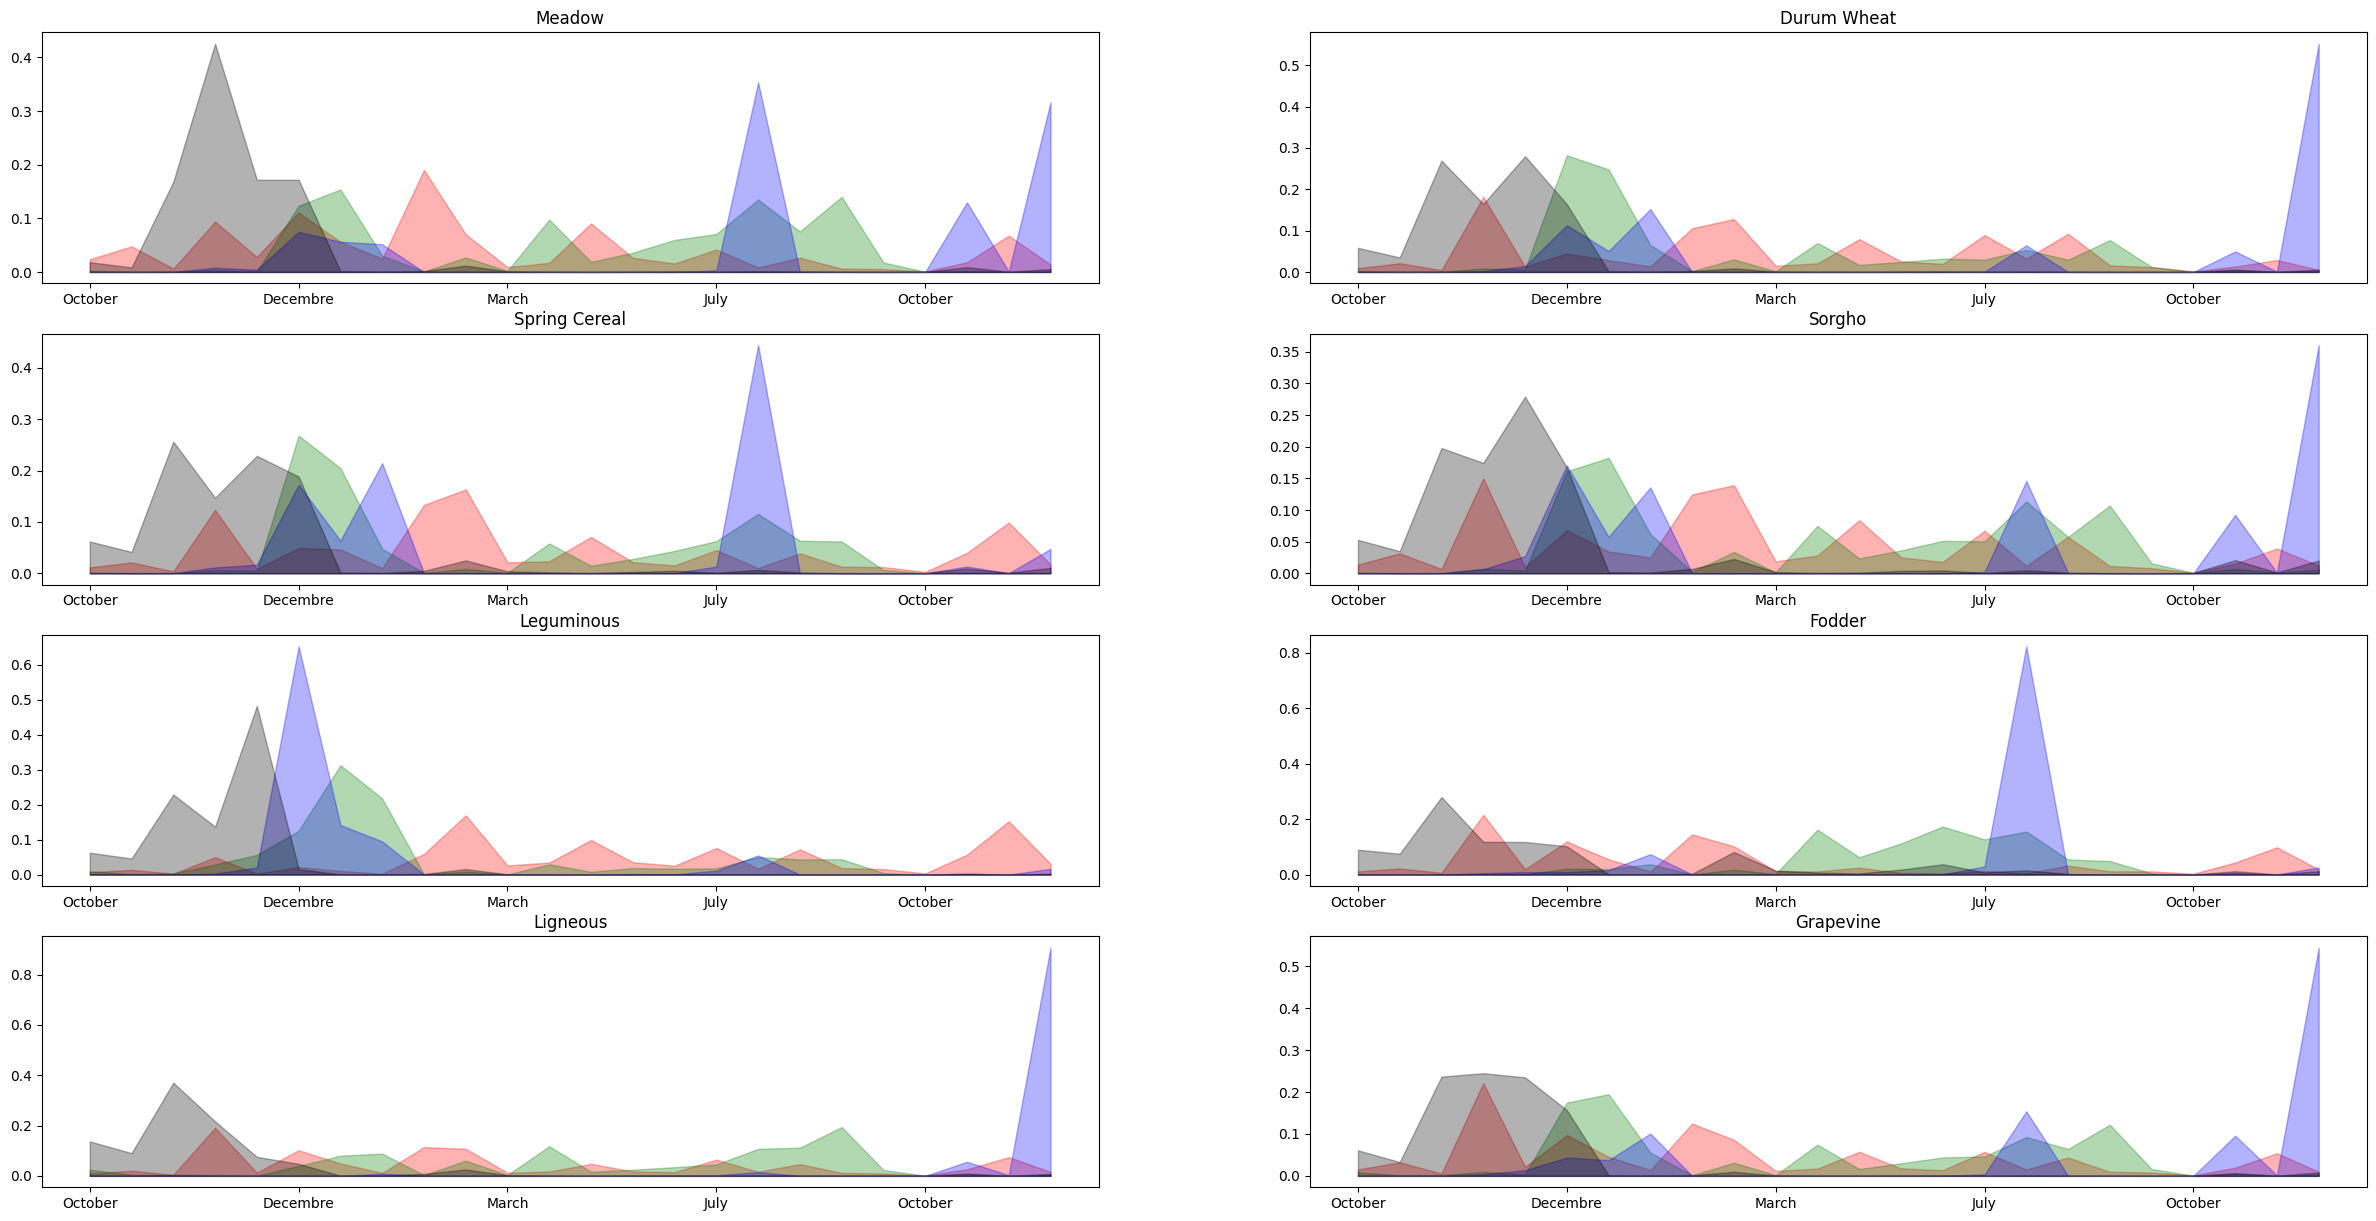

In [ ]:
fig = plt.figure(figsize=(30,15))
section = np.arange(24)

for i_class in range(8):
  ax = fig.add_subplot(4, 2, i_class+1)
  ax.set_title(class_names[i_class])
  plt.fill_between(section,average_attention[i_class,0,:], color='r', alpha=.3)
  plt.fill_between(section,average_attention[i_class,1,:], color='g', alpha=.3)
  plt.fill_between(section,average_attention[i_class,2,:], color='b', alpha=.3)
  plt.fill_between(section,average_attention[i_class,3,:], color='k', alpha=.3)
  ax.set_xticklabels(['', 'October','Decembre','March','July','October'])


## 2.8 Spatial Convolutions and Temporal Attention (CNN_TAE)

Replace the MLP encoder by a CNN.

Q11) Complete the following cell.

In [ ]:
class CNN_TAE(nn.Module):
    def __init__(self, n_channels, embed_size, key_size, n_heads, seq_length, n_class, return_masks=False, cuda=True):
        """
        CNN + TAE Model
        Args:
            n_channels (int): Number of input channels
            embed_size (int): Size of the embeddings (E)
            key_size (int): Size of the keys (K)
            n_heads (int): Number of attention heads (H)
            seq_length (int): Length of the sequence (T)
            n_class (int): Number of classes
            return_masks (bool): Whether to return attention masks
            cuda (bool): Use GPU if available
        """
        super(CNN_TAE, self).__init__()

        self.is_cuda = cuda
        self.embed_size = embed_size
        self.key_size = key_size
        self.n_heads = n_heads
        self.seq_length = seq_length
        self.n_class = n_class
        self.return_masks = return_masks

        # CNN feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(n_channels, embed_size, kernel_size=1),
            nn.BatchNorm2d(embed_size),
            nn.ReLU(),
            nn.Conv2d(embed_size, embed_size, kernel_size=1),
            nn.BatchNorm2d(embed_size),
            nn.ReLU()
        )

        # Temporal Attention Encoder (TAE)
        self.tae_temporal = TAE(embed_size, key_size, n_heads, seq_length, return_masks, cuda=cuda)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU(),
            nn.Linear(embed_size, embed_size // 2),
            nn.BatchNorm1d(embed_size // 2),
            nn.ReLU(),
            nn.Linear(embed_size // 2, n_class)
        )

        if cuda:
            self.cuda()

    def forward(self, x):
        """
        Forward pass
        Args:
            x (Tensor): Input tensor of shape (B, T, C, X, Y)
        Returns:
            Tensor: Output classification tensor (B, n_class)
        """
        if self.is_cuda:
            x = x.cuda()

        B, T, C, X, Y = x.shape

        # Reshape input for CNN (merge B and T)
        x = x.view(B * T, C, X, Y)  # -> (B*T, C, X, Y)
        x = self.feature_extractor(x)  # -> (B*T, E, X, Y)

        # Flatten spatial dimensions and reshape back to (B, T, E)
        x = x.mean(dim=[2, 3])  # Global average pooling over X, Y -> (B*T, E)
        x = x.view(B, T, self.embed_size)  # -> (B, T, E)

        # Apply TAE
        x = self.tae_temporal(x)  # -> (B, E)

        # Classification
        x = self.classifier(x)  # -> (B, n_class)

        return x



toy_test(CNN_TAE(10,128,8,4,24,8, cuda=torch.cuda.is_available()))

CNN_TAE(
  (feature_extractor): Sequential(
    (0): Conv2d(10, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (tae_temporal): TAE(
    (to_keys): Linear(in_features=128, out_features=32, bias=True)
    (to_values): Linear(in_features=128, out_features=128, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=8, bias=True)
  )
)


In [ ]:
#create the model to train
args = mock.Mock() #stores the parameters
args.n_epoch = 30 #number of epochs
args.batch_size = 16 #size of batch
args.n_channel = 10 #number of channels
args.embed_size = 160 #size of parcel embedding
args.key_size = 8 #size of parcel embedding
args.n_head = 4 #size of parcel embedding
args.seq_length = 24 #size of parcel embedding
args.n_class = 8 #number of classes
args.cuda = torch.cuda.is_available() #1: use the GPU, 0: use CPU (slow!)
args.lr = 5e-3 #learning rate

#create the model to train
cnn_tae = CNN_TAE(args.n_channel, args.embed_size, args.key_size,
                        args.n_head,  args.seq_length, args.n_class,
                        cuda=args.cuda)

print(cnn_tae)
print('Total number of parameters: {}'.format(sum([p.numel() for p in cnn_tae.parameters()])))
print('Parameters in spatial module: {}'.format(sum([p.numel() for p in cnn_tae.feature_extractor.parameters()])))
print('Parameters in temporal module: {}'.format(sum([p.numel() for p in cnn_tae.tae_temporal.parameters()])))
print('Parameters in classifier module: {}'.format(sum([p.numel() for p in cnn_tae.classifier.parameters()])))

#train the model
trained_cnn_tae = train_full(cnn_tae, args)

CNN_TAE(
  (feature_extractor): Sequential(
    (0): Conv2d(10, 160, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
    (4): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (tae_temporal): TAE(
    (to_keys): Linear(in_features=160, out_features=32, bias=True)
    (to_values): Linear(in_features=160, out_features=160, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=160, out_features=160, bias=True)
    (1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=160, out_features=80, bias=True)
    (4): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=80, out_features=8, bias=True)
  )
)
Total number of parameters: 

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch:   0%|                                                                                            …

Epoch   0 -> Train Overall Accuracy: 52.4% Train mIoU : 32.7% Train Loss: 1.3090


Validation:   0%|                                                                                             …

Epoch   0 -> Val Overall Accuracy: 59.5% Val mIoU : 39.1% Val Loss: 1.0824
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   0 -> Test Overall Accuracy: 59.38% Test mIoU : 39.72%  Test Loss: 1.1593
Meadow        :  57%
Durum Wheat   :  39%
Spring Cereal :  34%
Sorgho        :   3%
Leguminous    :  55%
Fodder        :  51%
Ligneous      :  69%
Grapevine     :  10%


Train Epoch:   0%|                                                                                            …

Epoch   1 -> Train Overall Accuracy: 62.1% Train mIoU : 43.0% Train Loss: 1.0681


Validation:   0%|                                                                                             …

Epoch   1 -> Val Overall Accuracy: 65.8% Val mIoU : 46.2% Val Loss: 0.9155
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   1 -> Test Overall Accuracy: 62.62% Test mIoU : 46.24%  Test Loss: 0.9474
Meadow        :  62%
Durum Wheat   :  35%
Spring Cereal :  41%
Sorgho        :   4%
Leguminous    :  87%
Fodder        :  60%
Ligneous      :  71%
Grapevine     :  11%


Train Epoch:   0%|                                                                                            …

Epoch   2 -> Train Overall Accuracy: 64.9% Train mIoU : 46.3% Train Loss: 0.9663


Validation:   0%|                                                                                             …

Epoch   2 -> Val Overall Accuracy: 50.8% Val mIoU : 31.6% Val Loss: 1.1895


Train Epoch:   0%|                                                                                            …

Epoch   3 -> Train Overall Accuracy: 66.4% Train mIoU : 48.1% Train Loss: 0.9094


Validation:   0%|                                                                                             …

Epoch   3 -> Val Overall Accuracy: 74.0% Val mIoU : 56.9% Val Loss: 0.7503
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch   3 -> Test Overall Accuracy: 70.38% Test mIoU : 55.35%  Test Loss: 0.7885
Meadow        :  73%
Durum Wheat   :  42%
Spring Cereal :  58%
Sorgho        :  28%
Leguminous    :  87%
Fodder        :  63%
Ligneous      :  73%
Grapevine     :  19%


Train Epoch:   0%|                                                                                            …

Epoch   4 -> Train Overall Accuracy: 68.2% Train mIoU : 50.5% Train Loss: 0.8490


Validation:   0%|                                                                                             …

Epoch   4 -> Val Overall Accuracy: 68.2% Val mIoU : 48.3% Val Loss: 0.8664


Train Epoch:   0%|                                                                                            …

Epoch   5 -> Train Overall Accuracy: 70.1% Train mIoU : 52.6% Train Loss: 0.8176


Validation:   0%|                                                                                             …

Epoch   5 -> Val Overall Accuracy: 72.0% Val mIoU : 55.1% Val Loss: 0.8639


Train Epoch:   0%|                                                                                            …

Epoch   6 -> Train Overall Accuracy: 68.9% Train mIoU : 51.3% Train Loss: 0.8165


Validation:   0%|                                                                                             …

Epoch   6 -> Val Overall Accuracy: 62.5% Val mIoU : 44.5% Val Loss: 1.0300


Train Epoch:   0%|                                                                                            …

Epoch   7 -> Train Overall Accuracy: 71.9% Train mIoU : 54.8% Train Loss: 0.7816


Validation:   0%|                                                                                             …

Epoch   7 -> Val Overall Accuracy: 70.8% Val mIoU : 53.7% Val Loss: 0.9089


Train Epoch:   0%|                                                                                            …

Epoch   8 -> Train Overall Accuracy: 72.8% Train mIoU : 56.2% Train Loss: 0.7576


Validation:   0%|                                                                                             …

Epoch   8 -> Val Overall Accuracy: 68.8% Val mIoU : 53.0% Val Loss: 0.9108


Train Epoch:   0%|                                                                                            …

Epoch   9 -> Train Overall Accuracy: 73.1% Train mIoU : 57.1% Train Loss: 0.7075


Validation:   0%|                                                                                             …

Epoch   9 -> Val Overall Accuracy: 72.8% Val mIoU : 53.5% Val Loss: 0.7428


Train Epoch:   0%|                                                                                            …

Epoch  10 -> Train Overall Accuracy: 73.8% Train mIoU : 57.5% Train Loss: 0.7234


Validation:   0%|                                                                                             …

Epoch  10 -> Val Overall Accuracy: 74.5% Val mIoU : 56.6% Val Loss: 0.7429


Train Epoch:   0%|                                                                                            …

Epoch  11 -> Train Overall Accuracy: 74.4% Train mIoU : 58.4% Train Loss: 0.7142


Validation:   0%|                                                                                             …

Epoch  11 -> Val Overall Accuracy: 71.0% Val mIoU : 55.8% Val Loss: 0.8238


Train Epoch:   0%|                                                                                            …

Epoch  12 -> Train Overall Accuracy: 73.9% Train mIoU : 58.0% Train Loss: 0.6937


Validation:   0%|                                                                                             …

Epoch  12 -> Val Overall Accuracy: 70.2% Val mIoU : 50.8% Val Loss: 0.8535


Train Epoch:   0%|                                                                                            …

Epoch  13 -> Train Overall Accuracy: 75.8% Train mIoU : 60.4% Train Loss: 0.6649


Validation:   0%|                                                                                             …

Epoch  13 -> Val Overall Accuracy: 72.8% Val mIoU : 56.6% Val Loss: 0.7731


Train Epoch:   0%|                                                                                            …

Epoch  14 -> Train Overall Accuracy: 75.6% Train mIoU : 60.3% Train Loss: 0.6640


Validation:   0%|                                                                                             …

Epoch  14 -> Val Overall Accuracy: 75.0% Val mIoU : 57.9% Val Loss: 0.7431
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  14 -> Test Overall Accuracy: 67.88% Test mIoU : 53.15%  Test Loss: 0.9269
Meadow        :  71%
Durum Wheat   :  37%
Spring Cereal :  63%
Sorgho        :   3%
Leguminous    :  86%
Fodder        :  69%
Ligneous      :  78%
Grapevine     :  16%


Train Epoch:   0%|                                                                                            …

Epoch  15 -> Train Overall Accuracy: 75.8% Train mIoU : 60.6% Train Loss: 0.6159


Validation:   0%|                                                                                             …

Epoch  15 -> Val Overall Accuracy: 68.8% Val mIoU : 52.2% Val Loss: 0.8160


Train Epoch:   0%|                                                                                            …

Epoch  16 -> Train Overall Accuracy: 76.2% Train mIoU : 60.9% Train Loss: 0.6390


Validation:   0%|                                                                                             …

Epoch  16 -> Val Overall Accuracy: 77.5% Val mIoU : 62.5% Val Loss: 0.5684
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  16 -> Test Overall Accuracy: 74.50% Test mIoU : 60.58%  Test Loss: 0.7350
Meadow        :  70%
Durum Wheat   :  40%
Spring Cereal :  72%
Sorgho        :  39%
Leguminous    :  75%
Fodder        :  69%
Ligneous      :  85%
Grapevine     :  35%


Train Epoch:   0%|                                                                                            …

Epoch  17 -> Train Overall Accuracy: 78.8% Train mIoU : 64.7% Train Loss: 0.5900


Validation:   0%|                                                                                             …

Epoch  17 -> Val Overall Accuracy: 75.5% Val mIoU : 60.5% Val Loss: 0.6870


Train Epoch:   0%|                                                                                            …

Epoch  18 -> Train Overall Accuracy: 78.4% Train mIoU : 64.1% Train Loss: 0.6064


Validation:   0%|                                                                                             …

Epoch  18 -> Val Overall Accuracy: 68.2% Val mIoU : 49.1% Val Loss: 0.8446


Train Epoch:   0%|                                                                                            …

Epoch  19 -> Train Overall Accuracy: 78.4% Train mIoU : 64.2% Train Loss: 0.6025


Validation:   0%|                                                                                             …

Epoch  19 -> Val Overall Accuracy: 71.5% Val mIoU : 54.8% Val Loss: 0.7363


Train Epoch:   0%|                                                                                            …

Epoch  20 -> Train Overall Accuracy: 80.2% Train mIoU : 66.5% Train Loss: 0.5729


Validation:   0%|                                                                                             …

Epoch  20 -> Val Overall Accuracy: 72.2% Val mIoU : 56.8% Val Loss: 0.7849


Train Epoch:   0%|                                                                                            …

Epoch  21 -> Train Overall Accuracy: 79.7% Train mIoU : 65.7% Train Loss: 0.5797


Validation:   0%|                                                                                             …

Epoch  21 -> Val Overall Accuracy: 79.5% Val mIoU : 65.1% Val Loss: 0.5709
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  21 -> Test Overall Accuracy: 75.88% Test mIoU : 62.28%  Test Loss: 0.7580
Meadow        :  75%
Durum Wheat   :  46%
Spring Cereal :  74%
Sorgho        :  34%
Leguminous    :  88%
Fodder        :  78%
Ligneous      :  79%
Grapevine     :  25%


Train Epoch:   0%|                                                                                            …

Epoch  22 -> Train Overall Accuracy: 79.8% Train mIoU : 66.0% Train Loss: 0.5749


Validation:   0%|                                                                                             …

Epoch  22 -> Val Overall Accuracy: 77.5% Val mIoU : 62.8% Val Loss: 0.6298


Train Epoch:   0%|                                                                                            …

Epoch  23 -> Train Overall Accuracy: 77.9% Train mIoU : 63.7% Train Loss: 0.5796


Validation:   0%|                                                                                             …

Epoch  23 -> Val Overall Accuracy: 79.8% Val mIoU : 64.1% Val Loss: 0.5783


Train Epoch:   0%|                                                                                            …

Epoch  24 -> Train Overall Accuracy: 81.2% Train mIoU : 68.0% Train Loss: 0.5249


Validation:   0%|                                                                                             …

Epoch  24 -> Val Overall Accuracy: 78.5% Val mIoU : 64.5% Val Loss: 0.6144


Train Epoch:   0%|                                                                                            …

Epoch  25 -> Train Overall Accuracy: 81.1% Train mIoU : 68.1% Train Loss: 0.5227


Validation:   0%|                                                                                             …

Epoch  25 -> Val Overall Accuracy: 85.0% Val mIoU : 73.3% Val Loss: 0.4762
-> Best performance achieved!


Validation:   0%|                                                                                             …

Epoch  25 -> Test Overall Accuracy: 79.38% Test mIoU : 67.05%  Test Loss: 0.6096
Meadow        :  82%
Durum Wheat   :  49%
Spring Cereal :  75%
Sorgho        :  43%
Leguminous    :  86%
Fodder        :  75%
Ligneous      :  85%
Grapevine     :  41%


Train Epoch:   0%|                                                                                            …

Epoch  26 -> Train Overall Accuracy: 80.6% Train mIoU : 67.5% Train Loss: 0.5449


Validation:   0%|                                                                                             …

Epoch  26 -> Val Overall Accuracy: 74.5% Val mIoU : 60.0% Val Loss: 0.7989


Train Epoch:   0%|                                                                                            …

Epoch  27 -> Train Overall Accuracy: 81.4% Train mIoU : 68.6% Train Loss: 0.5139


Validation:   0%|                                                                                             …

Epoch  27 -> Val Overall Accuracy: 81.5% Val mIoU : 68.2% Val Loss: 0.5426


Train Epoch:   0%|                                                                                            …

Epoch  28 -> Train Overall Accuracy: 81.4% Train mIoU : 68.6% Train Loss: 0.5157


Validation:   0%|                                                                                             …

Epoch  28 -> Val Overall Accuracy: 80.5% Val mIoU : 67.3% Val Loss: 0.5671


Train Epoch:   0%|                                                                                            …

Epoch  29 -> Train Overall Accuracy: 81.5% Train mIoU : 69.0% Train Loss: 0.5230


Validation:   0%|                                                                                             …

Epoch  29 -> Val Overall Accuracy: 84.0% Val mIoU : 71.4% Val Loss: 0.4509


## 2.9 Your Best Design

Q12) Chose your favorite model and use all the tools seen in previous TDs (dropout, learning rate scheduler, hyper-parametrization search, augmentations, etc)  to get the highest score possible. Explain succintly your design choices.
<font color='blue'>
I chose cnn_tae as my model because it has the highest overall accuracy (OA = 84.0%) and mean intersection over union (mIoU = 71.4%). To further improve its performance, I applied various optimization techniques:


*   <font color='blue'>Dropout to reduce overfitting
*   Learning Rate Scheduler to ensure smooth convergence
*   Hyperparameter Search to find the best combination of batch size, learning rate, and activation functions
*   Data Augmentation (random rotations, flips, blurs) to improve generalization





**Data from**
Garnot, V. S. F., Landrieu, L., Giordano, S., & Chehata, N. Satellite Image Time Series Classification with Pixel-Set Encoders and Temporal Self-Attention. In CVPR 2020.

https://github.com/VSainteuf/pytorch-psetae